### PROJECT TITLE : RECENCY,FREQUENCY & MONETARY VALUE ANALYSIS WITH KMEANS

##### PROJECT OBJECTIVE : CUSTOMER-SEGMENTATION

In [264]:
## importing neccessary libararies  
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  
import pandas as pd 
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score ,calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier 
plt.rcParams['figure.figsize']=(20,8)
plt.rcParams['figure.dpi']=400
# plt.rcParams['figure.grid']=True
sns.set_style('darkgrid')
pd.set_option("display.max_columns",None)
from datetime import date as dt , timedelta
from sklearn.preprocessing import StandardScaler,RobustScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import silhouette_samples
from kmodes import kprototypes


In [265]:
# import data
retail_data= pd.read_csv(r'D:\python_data_analysis\datasets\Online_Retail.csv')

In [266]:
## check for the shape of the data  
retail_data.shape

(541909, 8)

In [267]:
## check for general info        
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [268]:
## checking for missing values 
retail_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [269]:
## checking for the perrcentage of missingness  
np.round(retail_data.isnull().mean()*100,3)

InvoiceNo       0.000
StockCode       0.000
Description     0.268
Quantity        0.000
InvoiceDate     0.000
UnitPrice       0.000
CustomerID     24.927
Country         0.000
dtype: float64

In [270]:
## dropping missing values from the data  
retail_data.dropna(inplace=True)
## check for missing values again  
retail_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [271]:
## checking for the size  
retail_data.shape

(406829, 8)

In [272]:
## checking for duplicates    
retail_data.duplicated(keep='first').sum()

np.int64(5225)

In [273]:
## dropping duplicates 
retail_data.drop_duplicates(inplace=True)
## checking for duplicates    
retail_data.duplicated(keep='first').sum()

np.int64(0)

In [274]:
## checking for the size  
retail_data.shape

(401604, 8)

In [275]:
## checking for descriptive stats  
retail_data.describe().T

count          mean          std      min       25%       50%  \
Quantity    401604.0     12.183273   250.283037 -80995.0      2.00      5.00   
UnitPrice   401604.0      3.474064    69.764035      0.0      1.25      1.95   
CustomerID  401604.0  15281.160818  1714.006089  12346.0  13939.00  15145.00   

                 75%      max  
Quantity       12.00  80995.0  
UnitPrice       3.75  38970.0  
CustomerID  16784.00  18287.0

In [276]:
# Removing negative values before procedding to calculate Revenue
retail_data = retail_data[(retail_data['Quantity']>0) & (retail_data['UnitPrice']>0)]

In [277]:
## creating the Total Revenue column 
retail_data.loc[:,'Total_Revenue'] = retail_data['Quantity'] * retail_data['UnitPrice'] 

In [278]:
## check the size  
retail_data.shape

(392692, 9)

In [279]:
## concerting the Invoice Date column to Datetime Index 
retail_data.loc[:,'InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])
## check for the info  
retail_data['InvoiceDate'].dtype 
## Adding the Month column       



dtype('O')

In [280]:
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])
# Create a 'Month' column 
retail_data['Month'] = retail_data['InvoiceDate'].dt.month_name()

# Define the order of months
month_order = [
    'January', 'February', 'March', 'April',
    'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]

# Convert 'Month' to a categorical column with the defined order
retail_data['Month'] = pd.Categorical(
    retail_data['Month'],
    categories=month_order,
    ordered=True
)

# Sort the DataFrame by the ordered 'Month' column
retail_data.sort_values(by='Month', inplace=True)

# Reset index for cleanliness
retail_data.reset_index(drop=True, inplace=True)



In [281]:
retail_data.head()

InvoiceNo StockCode                      Description  Quantity  \
0    541002     84050  PINK HEART SHAPE EGG FRYING PAN         6   
1    540261     22265  EASTER DECORATION NATURAL CHICK        24   
2    540261     22457  NATURAL SLATE HEART CHALKBOARD         48   
3    540261     21385  IVORY HANGING DECORATION  HEART        24   
4    540261     22469            HEART OF WICKER SMALL        48   

          InvoiceDate  UnitPrice  CustomerID         Country  Total_Revenue  \
0 2011-01-13 10:33:00       1.65     12951.0  United Kingdom            9.9   
1 2011-01-06 09:57:00       0.65     13089.0  United Kingdom           15.6   
2 2011-01-06 09:57:00       2.55     13089.0  United Kingdom          122.4   
3 2011-01-06 09:57:00       0.85     13089.0  United Kingdom           20.4   
4 2011-01-06 09:57:00       1.45     13089.0  United Kingdom           69.6   

     Month  
0  January  
1  January  
2  January  
3  January  
4  January

In [282]:
## creating the reference data  
reference_date = retail_data['InvoiceDate'].max() + timedelta(days=1)
## display the reference date
reference_date

Timestamp('2011-12-10 12:50:00')

In [283]:
## check the data again  
retail_data.head()

InvoiceNo StockCode                      Description  Quantity  \
0    541002     84050  PINK HEART SHAPE EGG FRYING PAN         6   
1    540261     22265  EASTER DECORATION NATURAL CHICK        24   
2    540261     22457  NATURAL SLATE HEART CHALKBOARD         48   
3    540261     21385  IVORY HANGING DECORATION  HEART        24   
4    540261     22469            HEART OF WICKER SMALL        48   

          InvoiceDate  UnitPrice  CustomerID         Country  Total_Revenue  \
0 2011-01-13 10:33:00       1.65     12951.0  United Kingdom            9.9   
1 2011-01-06 09:57:00       0.65     13089.0  United Kingdom           15.6   
2 2011-01-06 09:57:00       2.55     13089.0  United Kingdom          122.4   
3 2011-01-06 09:57:00       0.85     13089.0  United Kingdom           20.4   
4 2011-01-06 09:57:00       1.45     13089.0  United Kingdom           69.6   

     Month  
0  January  
1  January  
2  January  
3  January  
4  January

In [284]:
## grouping and creating the quantiles  
rfm_data = retail_data.groupby('CustomerID').agg( 
    Recency = ('InvoiceDate',lambda x: (reference_date - x.max()).days),  
    Frequency = ('InvoiceNo','nunique'), 
    Monetary = ('Total_Revenue','sum')
).reset_index()

In [285]:
## checking the data  
rfm_data.head()

CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

In [286]:
## checking the bottom last  
rfm_data.tail()

CustomerID  Recency  Frequency  Monetary
4333     18280.0      278          1    180.60
4334     18281.0      181          1     80.82
4335     18282.0        8          2    178.05
4336     18283.0        4         16   2045.53
4337     18287.0       43          3   1837.28

In [287]:
## checking the largest in Frequncy column 
rfm_data.nlargest(5,'Frequency')

CustomerID  Recency  Frequency   Monetary
326      12748.0        1        209   33053.19
1879     14911.0        1        201  143711.17
4010     17841.0        2        124   40519.84
562      13089.0        3         97   58762.08
1661     14606.0        1         93   12076.15

In [288]:
## checking the smallest in Recency column     
rfm_data.nsmallest(5,'Recency')

CustomerID  Recency  Frequency  Monetary
61      12423.0        1          8   1859.31
71      12433.0        1          7  13375.87
137     12518.0        1          5   2056.89
144     12526.0        1          3   1316.66
258     12662.0        1         11   3849.78

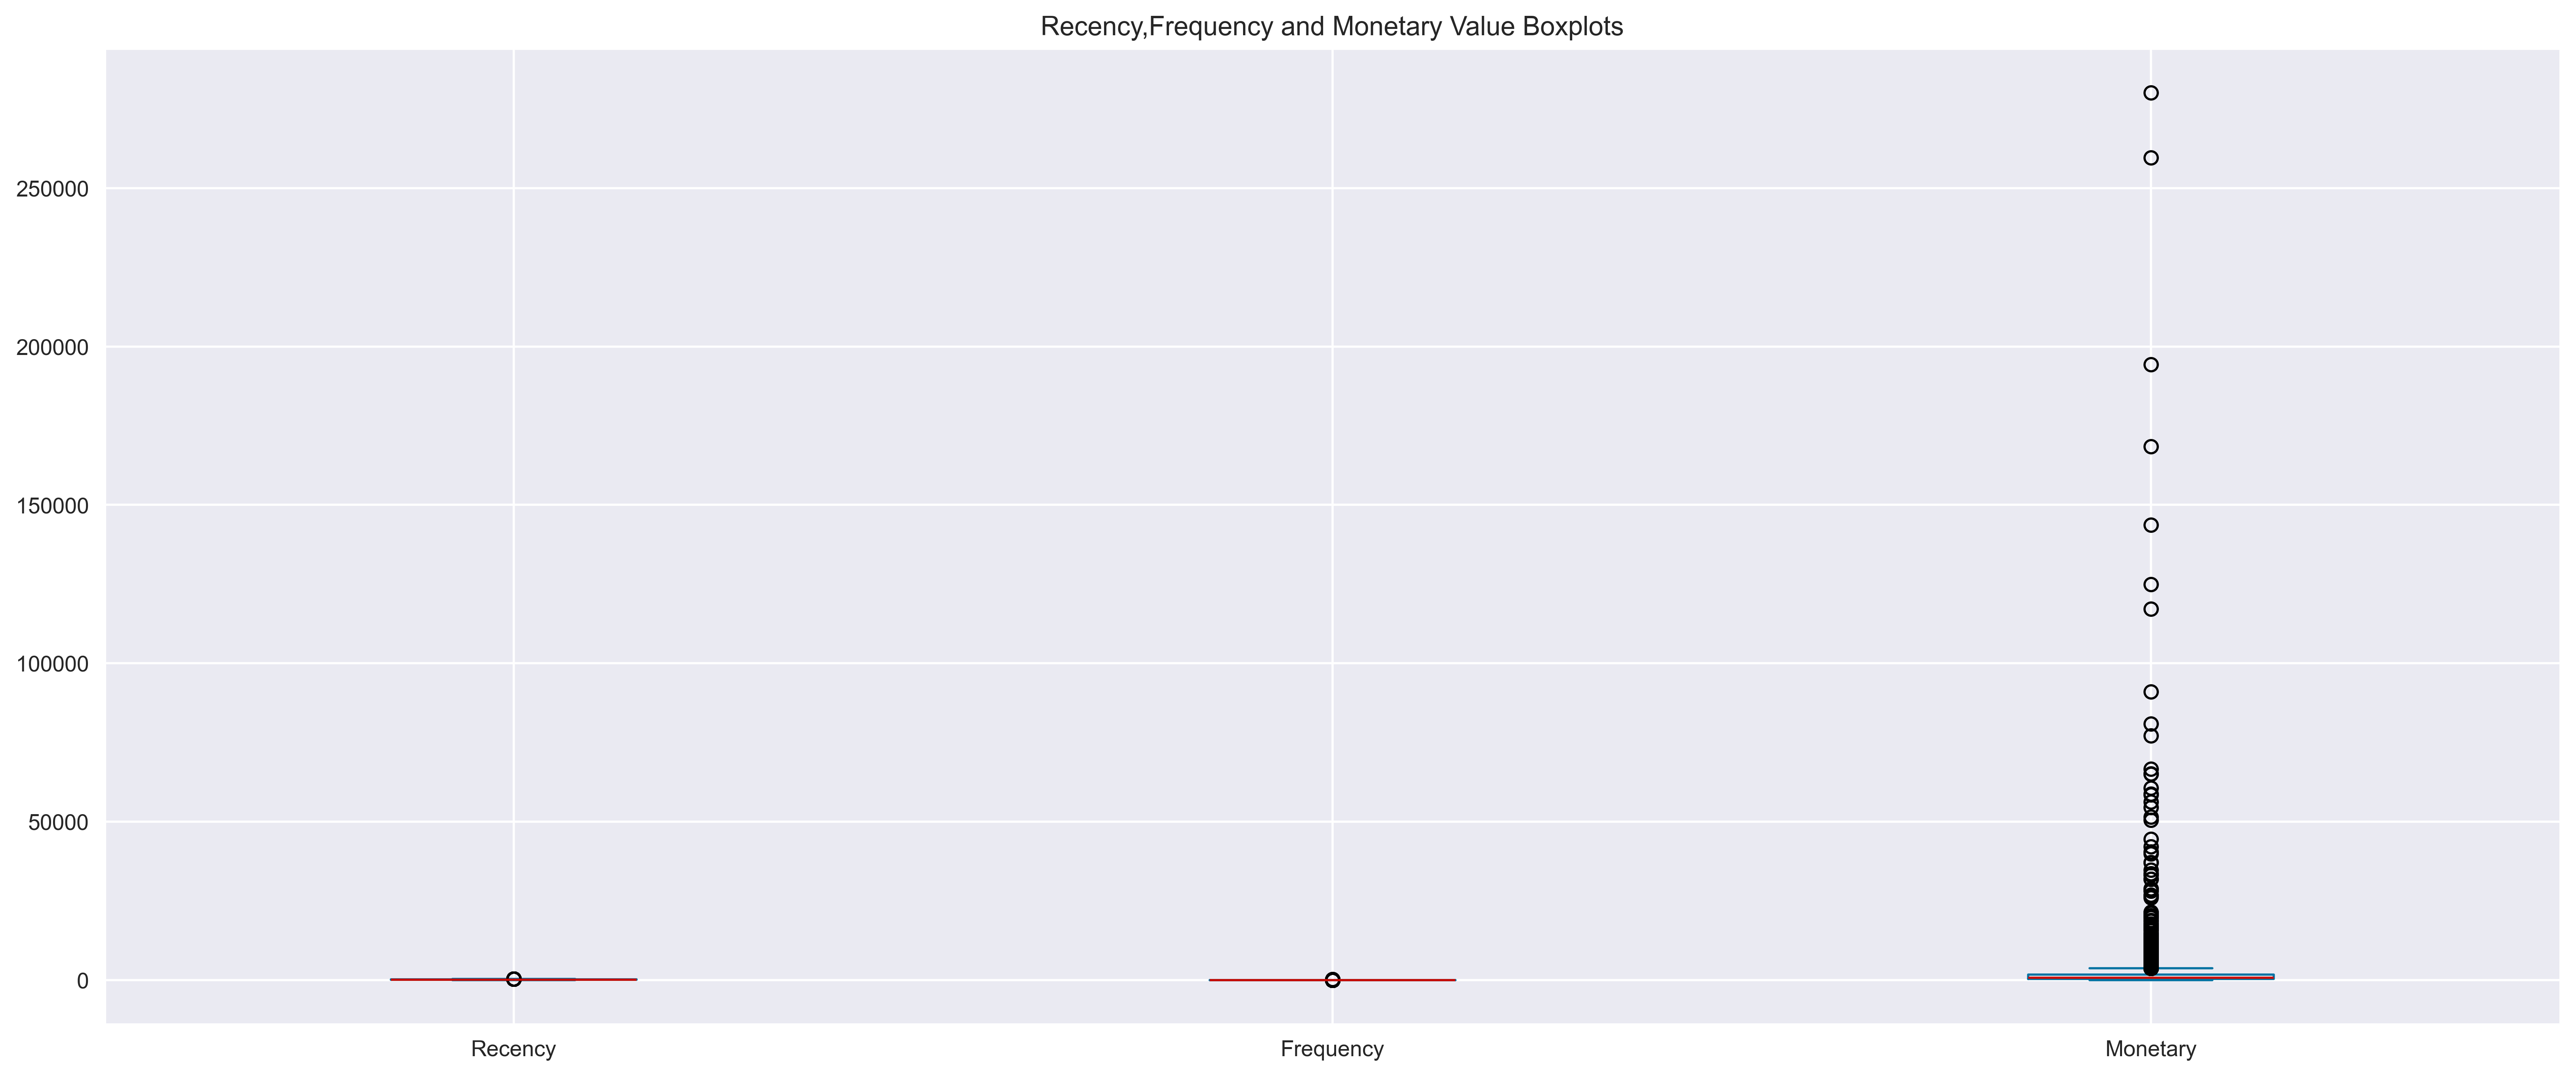

In [289]:
## RFM visualizations  
## create a box plot  
rfm_data[['Recency','Frequency','Monetary']].plot.box()
plt.title("Recency,Frequency and Monetary Value Boxplots")
plt.show()

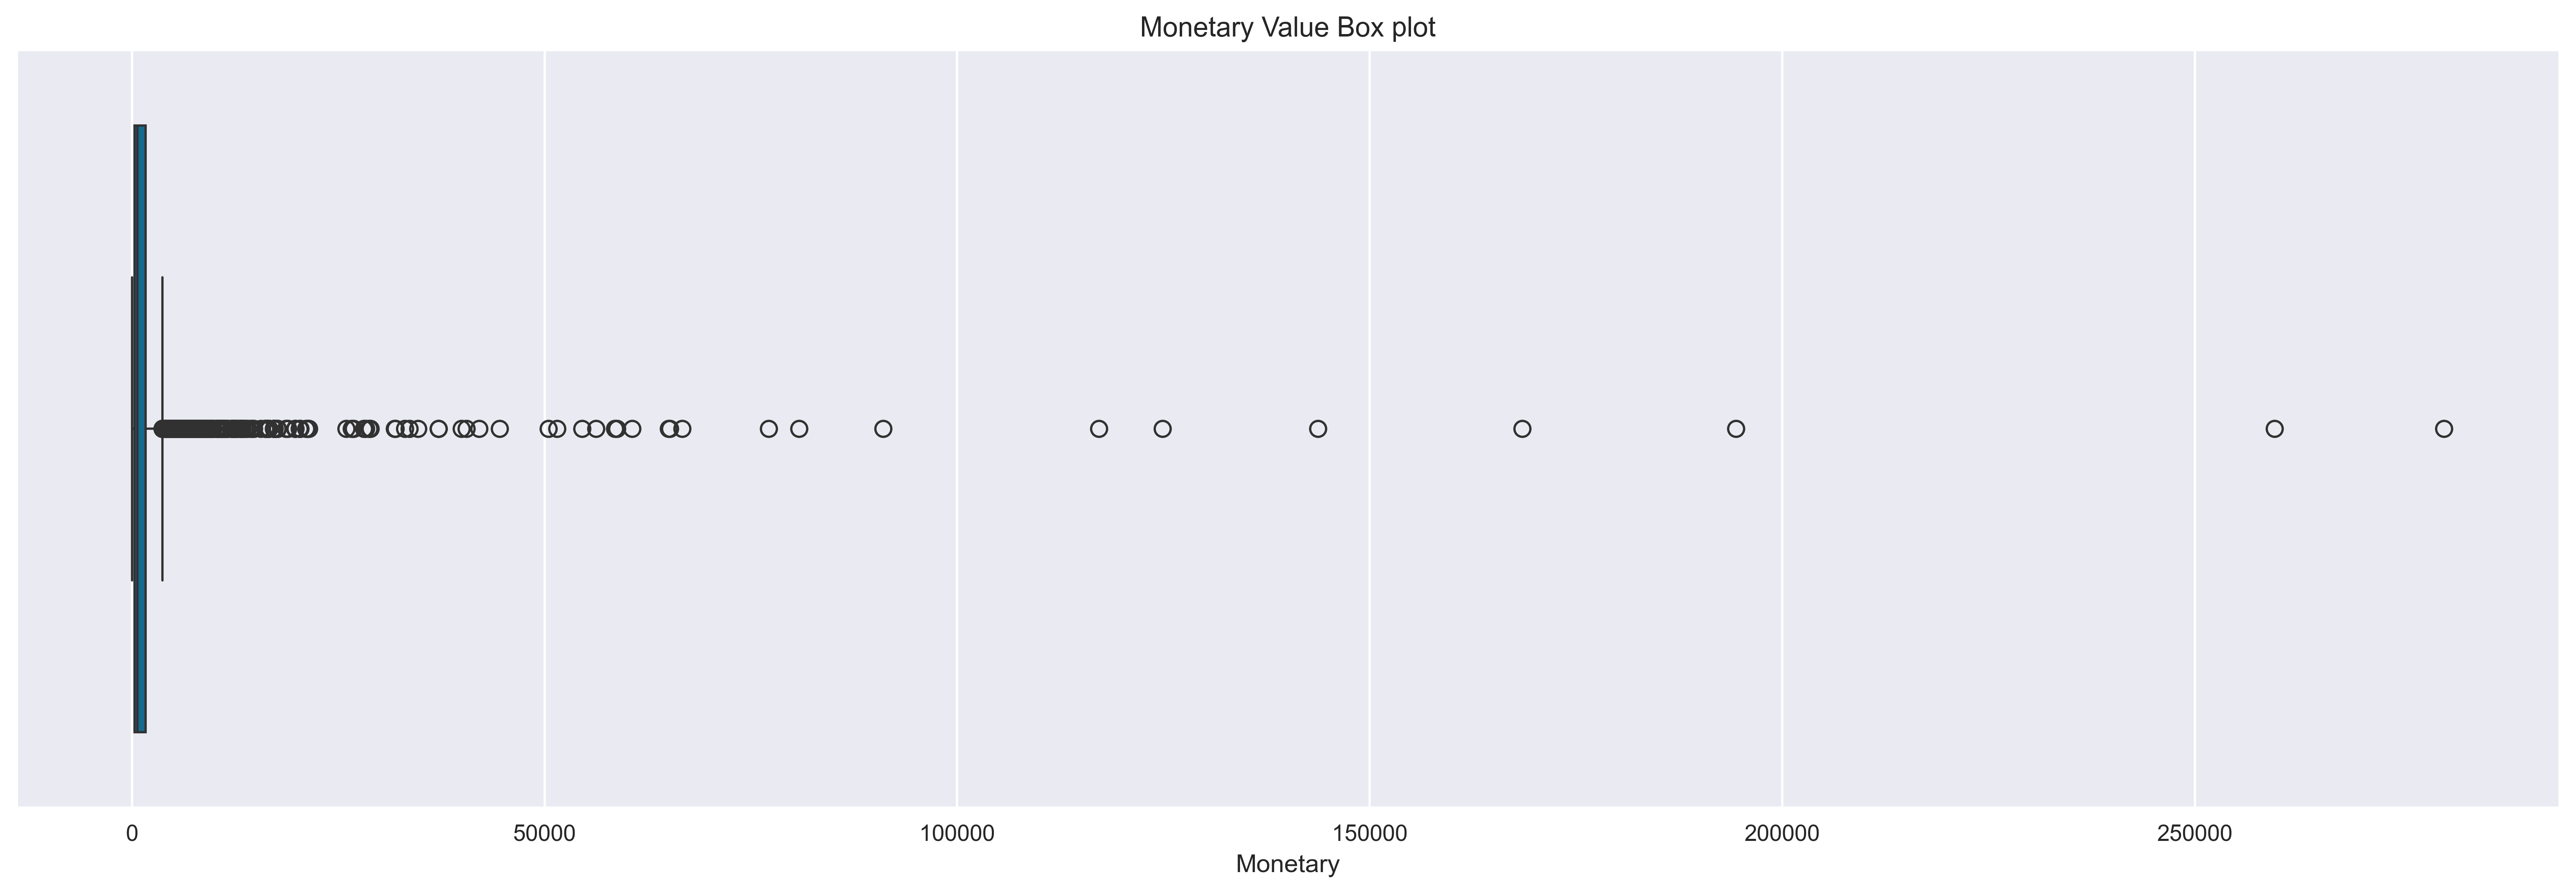

In [290]:
## Box-Plot for Monetery Value 
plt.figure(figsize=(20,6)) 
sns.boxplot(data=rfm_data , x='Monetary',orient='h')
plt.title('Monetary Value Box plot')
plt.show()

In [291]:
# # Log-transform Monetary to reduce outlier impact  
# rfm_data['Monetary_log'] = np.log1p(rfm_data['Monetary'])  
# rfm_data['Frequency_log'] = np.log1p(rfm_data['Frequency']) 
# rfm_data['Recency_log'] = np.log1p(rfm_data['Recency']) 

In [292]:
## checking for the descriptive statistics of rfm data 
rfm_data.describe().T

count          mean          std       min         25%       50%  \
CustomerID  4338.0  15300.408022  1721.808492  12346.00  13813.2500  15299.50   
Recency     4338.0     92.536422   100.014169      1.00     18.0000     51.00   
Frequency   4338.0      4.272015     7.697998      1.00      1.0000      2.00   
Monetary    4338.0   2048.688081  8985.230220      3.75    306.4825    668.57   

                   75%        max  
CustomerID  16778.7500   18287.00  
Recency       142.0000     374.00  
Frequency       5.0000     209.00  
Monetary     1660.5975  280206.02

In [293]:
## creating rfm scores  
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'],q=5,labels=False,duplicates='drop')+1
##  reversing the Recency  
rfm_data['R_Score'] = 6 -  rfm_data['R_Score']
## calculate for Frequency  
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'),q=5,labels=False,duplicates='drop')+1
## calculate the scores for Monetary  
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'].rank(method='first'),q=5,labels=False,duplicates='drop')+1
## adding the score line 
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)
## summing  
rfm_data['RFM_Total_Score'] = rfm_data[['R_Score','F_Score','M_Score']].sum(axis=1)
## display the data  
rfm_data.head()


CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0     12346.0      326          1  77183.60        1        1        5   
1     12347.0        2          7   4310.00        5        5        5   
2     12348.0       75          4   1797.24        2        4        4   
3     12349.0       19          1   1757.55        4        1        4   
4     12350.0      310          1    334.40        1        1        2   

  RFM_Score  RFM_Total_Score  
0       115                7  
1       555               15  
2       244               10  
3       414                9  
4       112                4

In [294]:
## standardizig the Recency , Frequency and Monetary values  
scaler = StandardScaler()
## apply it to the data 
rfm_data_scaled = scaler.fit_transform(rfm_data[['Recency','Frequency','Monetary']])
## transform the scaled data back to a dataframe  
rfm_data_scaled_df = pd.DataFrame(rfm_data_scaled , columns=['Recency','Frequency','Monetary'])
## show the scaled rfm data 
rfm_data_scaled_df.head()

Recency  Frequency  Monetary
0  2.334574  -0.425097  8.363010
1 -0.905340   0.354417  0.251699
2 -0.175360  -0.035340 -0.027988
3 -0.735345  -0.425097 -0.032406
4  2.174578  -0.425097 -0.190812

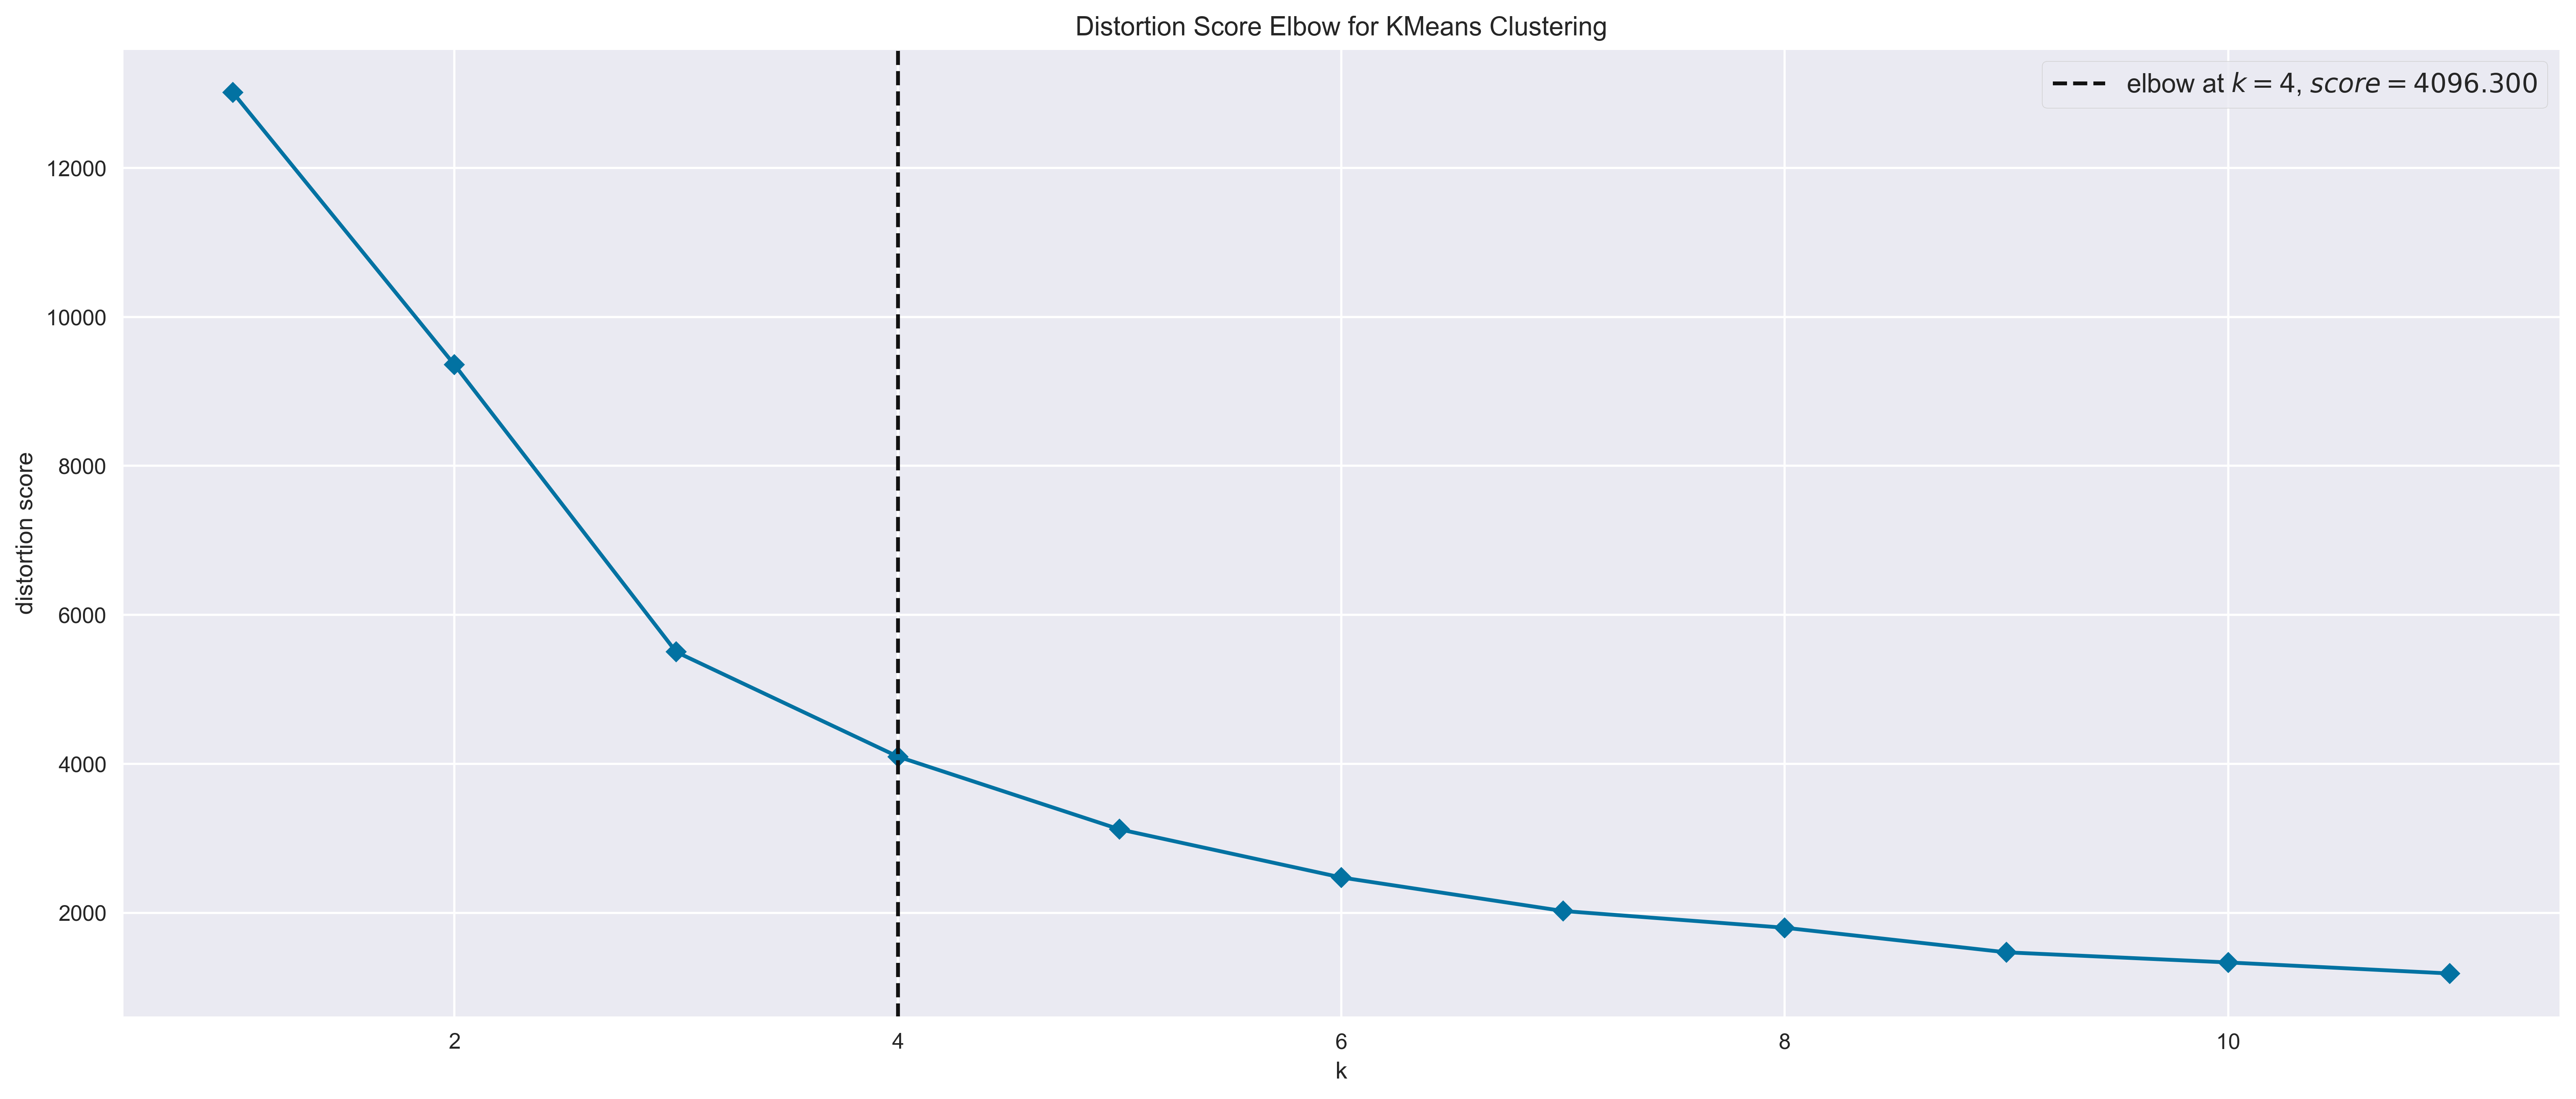

In [295]:
# Create the KElbowVisualizer with the distortion metric
## intialize the model  
model = KMeans(random_state=42)
## create the visualizer
visualizer = KElbowVisualizer(
    model,
    k=(1, 12),        
    metric="distortion", 
    timings=False       
)

# Fit the visualizer to the data
visualizer.fit(rfm_data_scaled)
visualizer.show();

### Using Calinski-Harabasz-Index

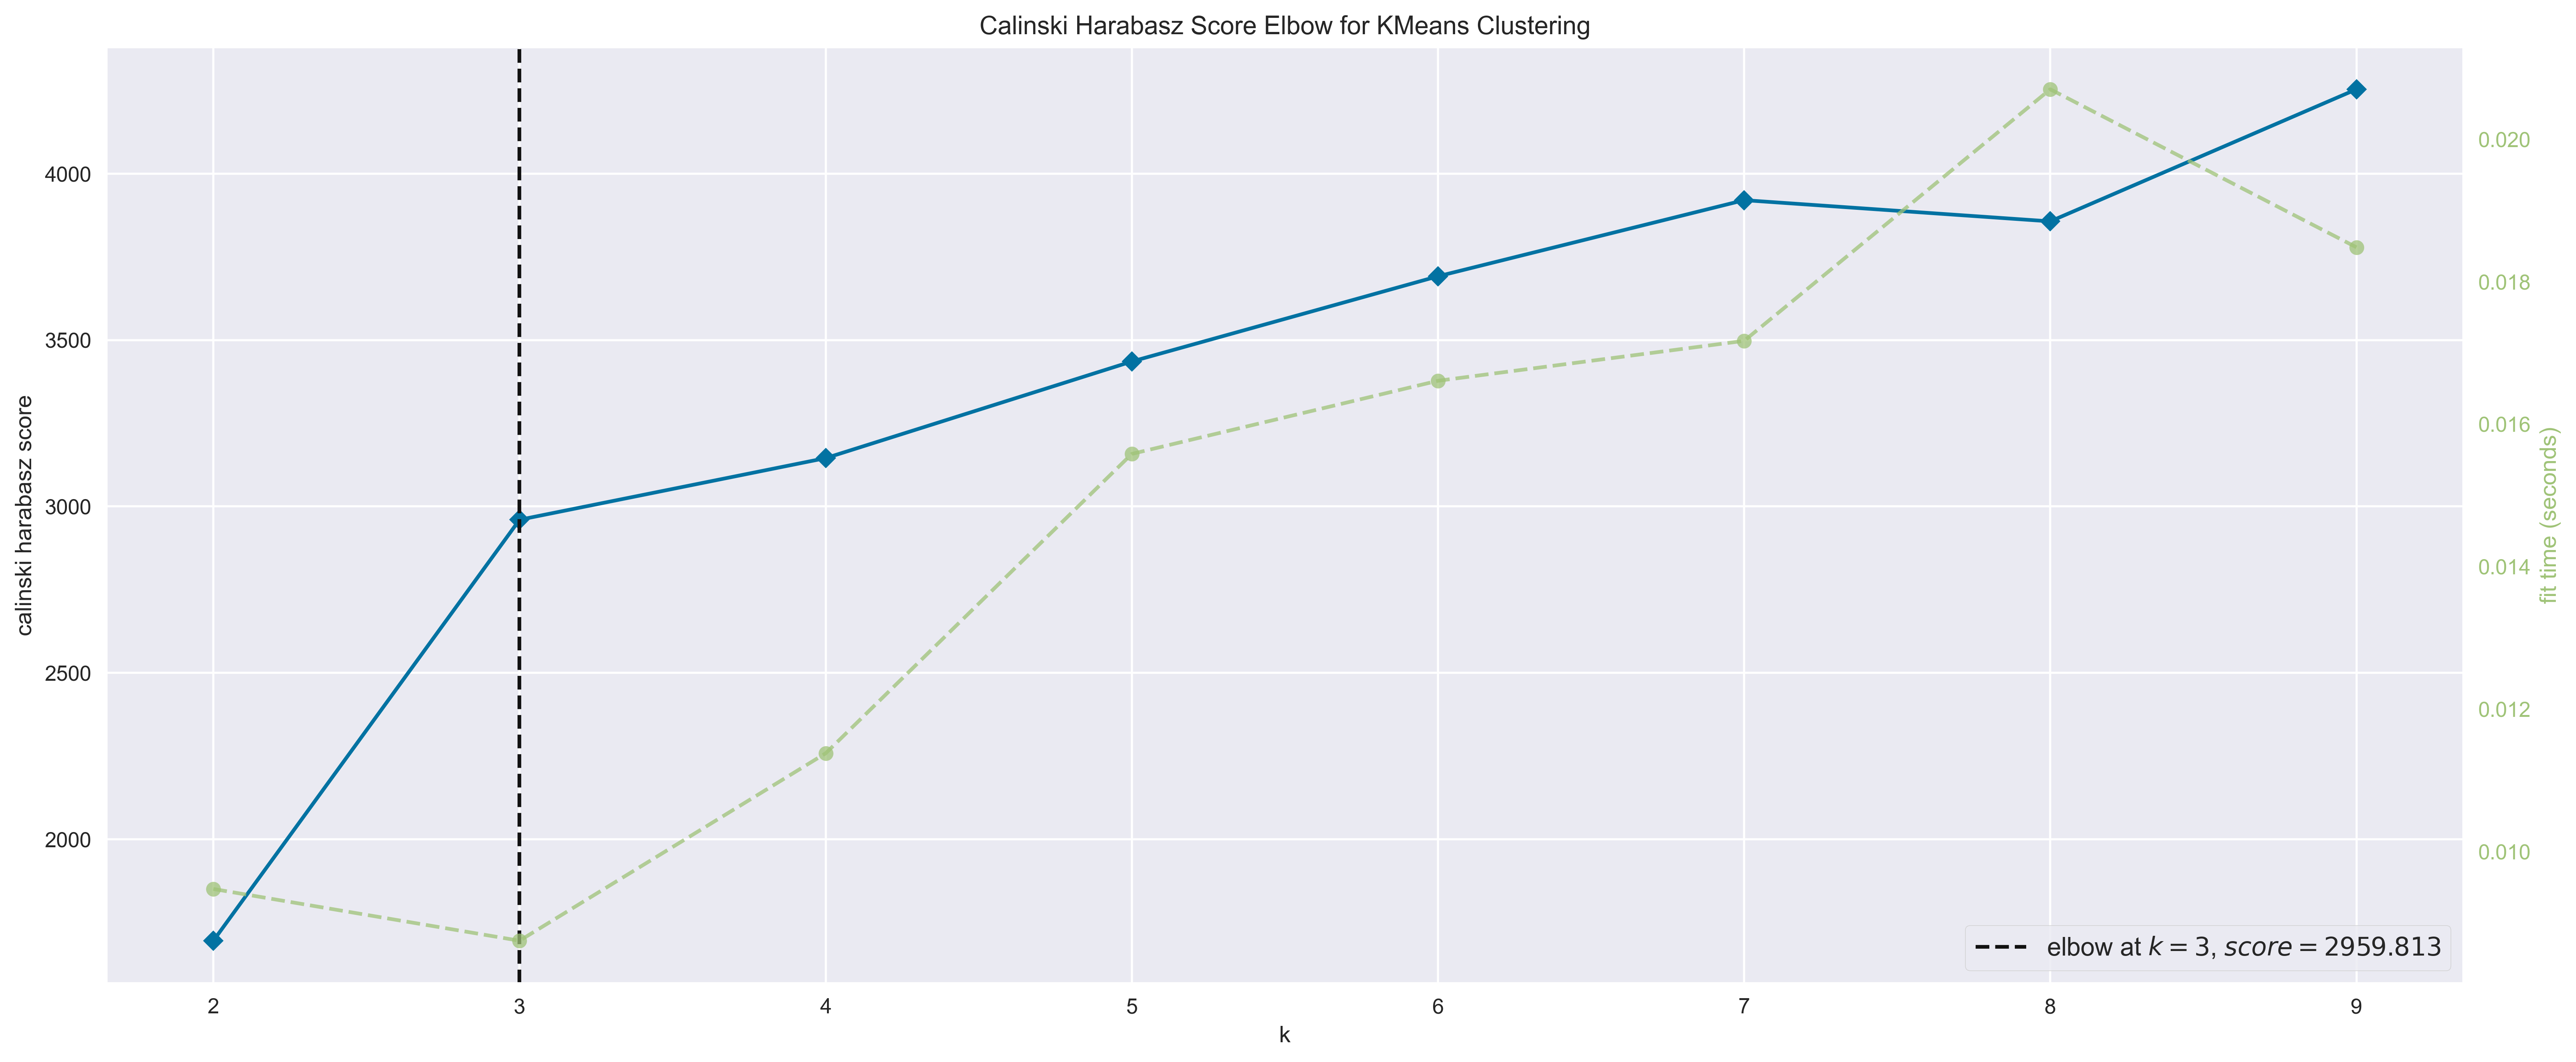

In [296]:

# Create the KElbowVisualizer with the Calinski-Harabasz metric
visualizer = KElbowVisualizer(
    model,
    k=(2, 10),          
    metric="calinski_harabasz",  
    timings=True        
)

# Fit the visualizer to the data
visualizer.fit(rfm_data_scaled) 
visualizer.show();

### USING-SILHOUETTE-SCORES

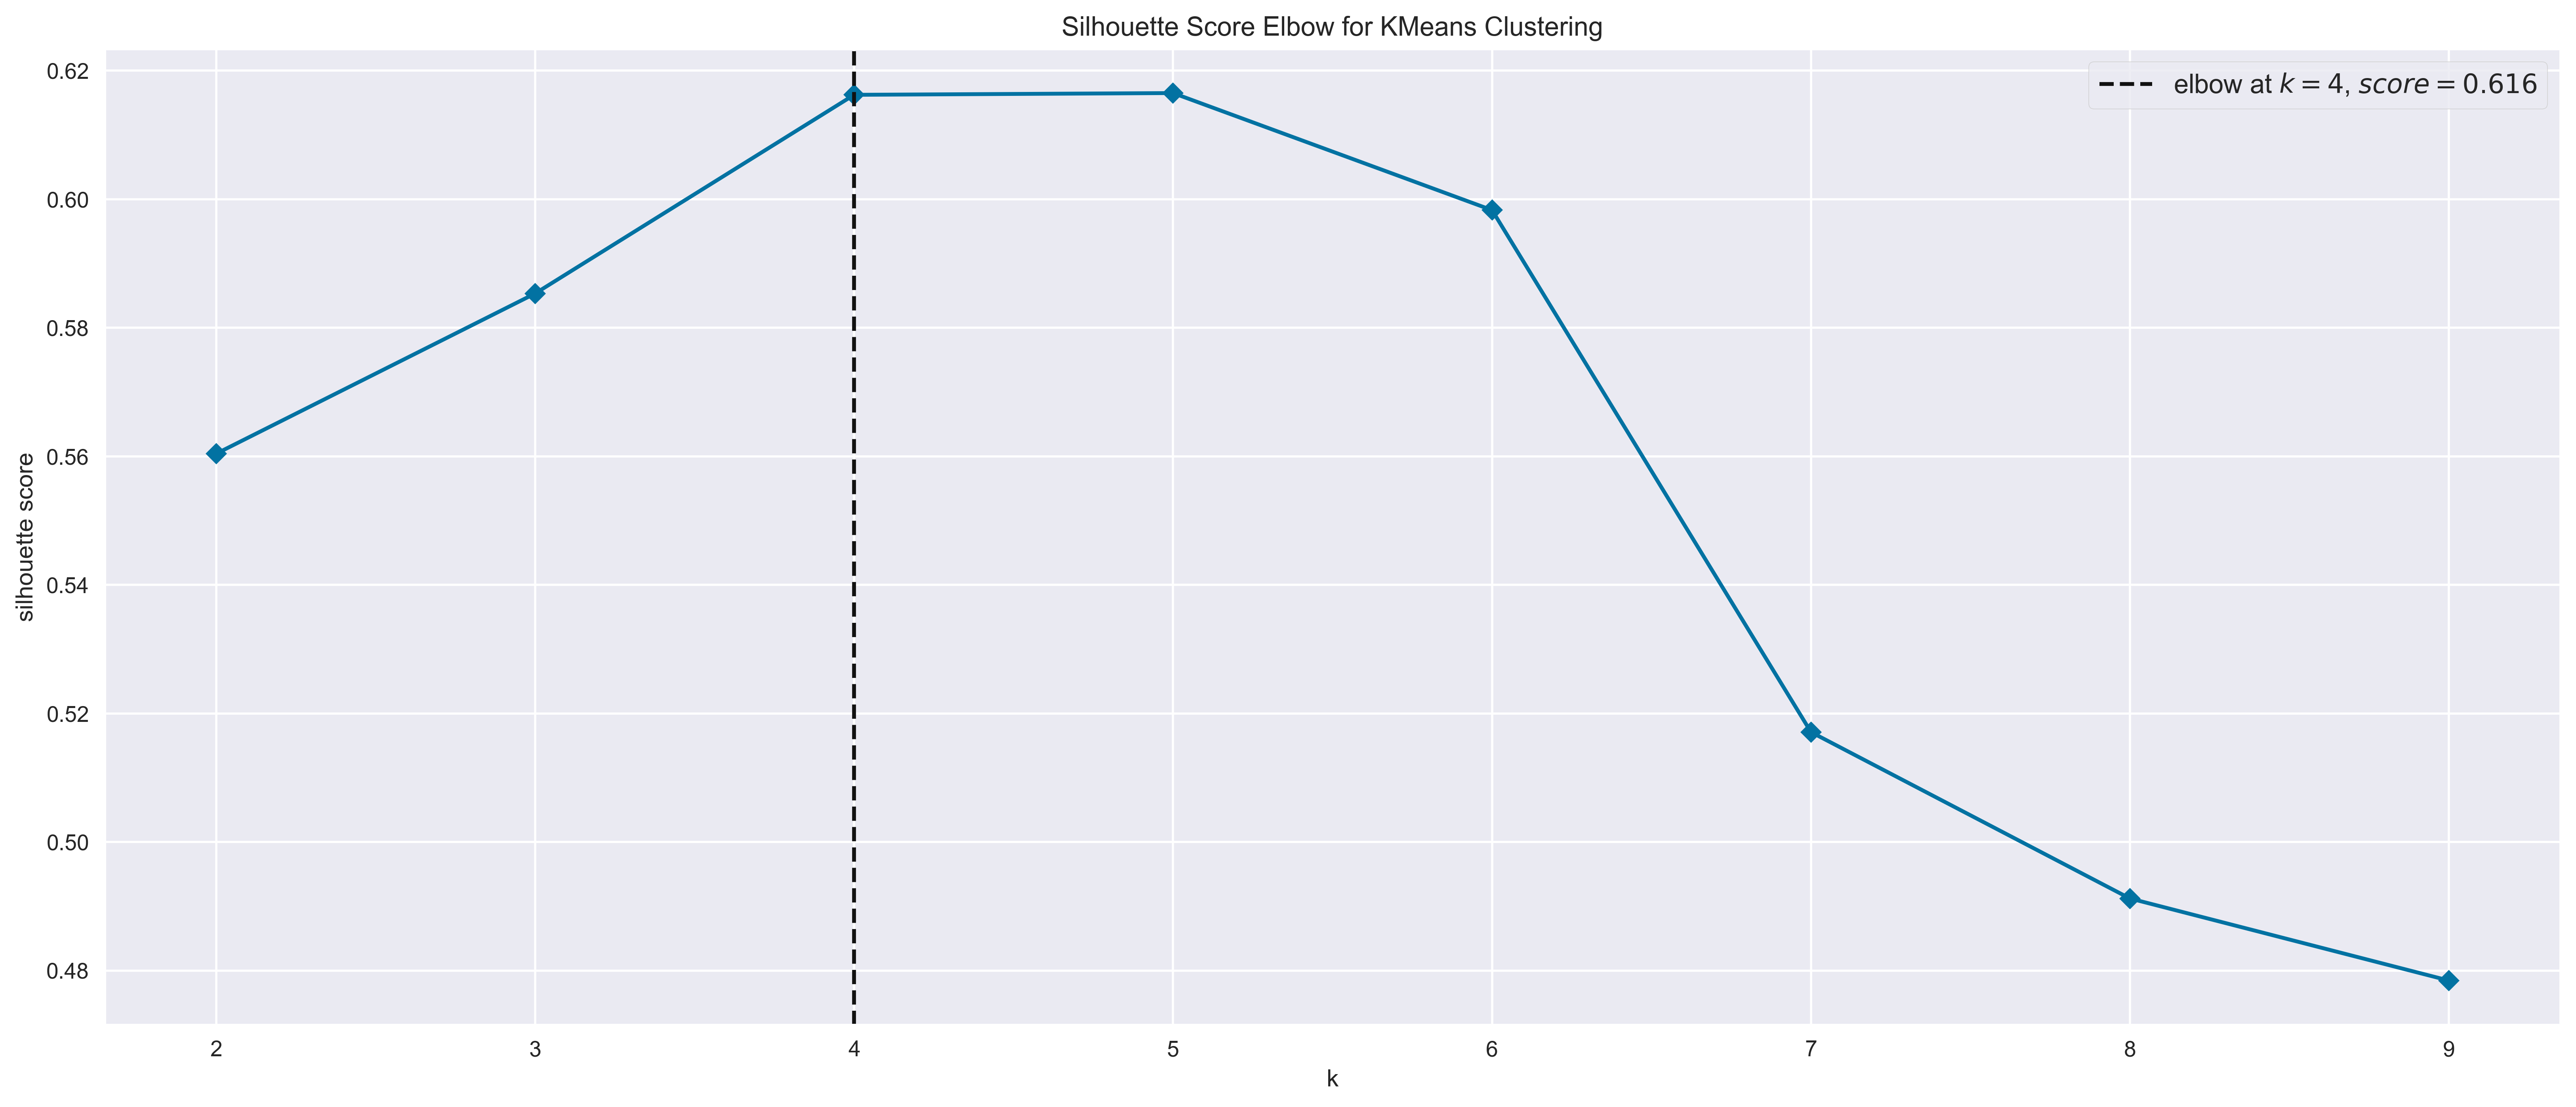

In [297]:

# Initialize the KMeans model
model = KMeans(random_state=42)

# Create the KElbowVisualizer with the Silhouette Score metric
visualizer = KElbowVisualizer(
    model,
    k=(2, 10),        
    metric="silhouette", 
    timings=False     
)

# Fit the visualizer
visualizer.fit(rfm_data_scaled)
visualizer.show();

### TRAINING-KMEANS-MODEL

In [298]:
## choosing the optimal k to be 4 clusters  
optimal_k_when_4 = 4 
optimal_k_when_3= 3


In [299]:
## fitting the model 
# Step 3: Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k_when_4,init='k-means++', random_state=42)
labels_ =   kmeans.fit_predict(rfm_data_scaled)
rfm_data_scaled_df['4_Cluster_Label'] = kmeans.fit_predict(rfm_data_scaled)
## when optimal k is 3 
kmeans = KMeans(n_clusters=optimal_k_when_3,init='k-means++', random_state=42)
rfm_data_scaled_df['3_Cluster_Label'] = kmeans.fit_predict(rfm_data_scaled)

In [300]:
## check the data  
rfm_data_scaled_df.head()

Recency  Frequency  Monetary  4_Cluster_Label  3_Cluster_Label
0  2.334574  -0.425097  8.363010                3                1
1 -0.905340   0.354417  0.251699                0                0
2 -0.175360  -0.035340 -0.027988                0                0
3 -0.735345  -0.425097 -0.032406                0                0
4  2.174578  -0.425097 -0.190812                1                1

### PRINCIPAL-COMPONENT-ANALYSIS

In [301]:
# Perform PCA without specifying n_components
pca = PCA()
## fit the data
pca.fit(rfm_data_scaled)
# Get explained variance ratio and cumulative variance
explained_variance_ratio = pca.explained_variance_ratio_
## cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

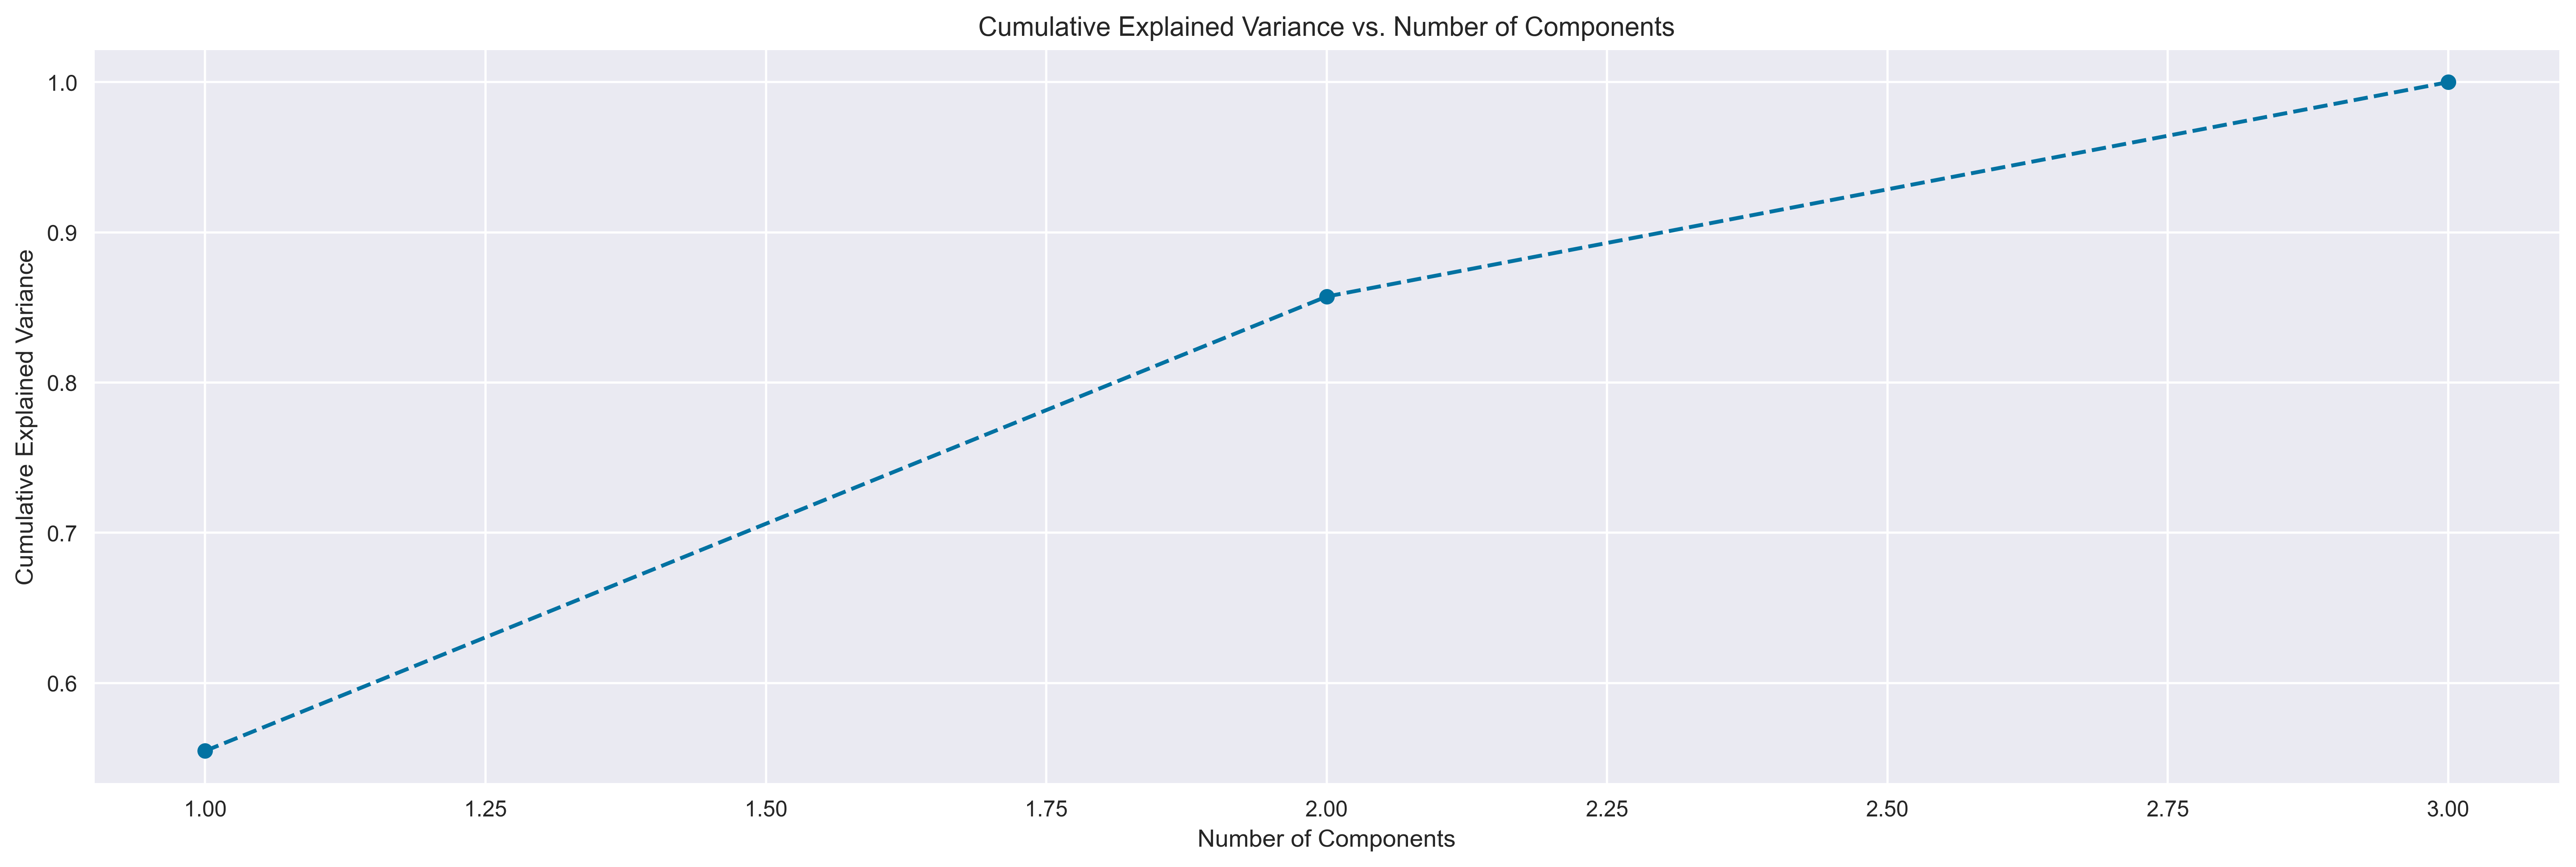

In [302]:
# Plot cumulative explained variance
plt.figure(figsize=(20, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [303]:
## select n_components based on 90% threshold
threshold = 0.80
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
print(f"Optimal number of components for 80% variance: {n_components}")

Optimal number of components for 80% variance: 2


In [304]:
# Apply PCA with 2 components
pca_final = PCA(n_components=n_components)
## fit and transform
rfm_pca = pca_final.fit_transform(rfm_data_scaled)

In [305]:
# Fit K-Means on the PCA-transformed data (corrected from original data)
kmeans = KMeans(n_clusters=4, init='k-means++',random_state=42)  
labels_pca = kmeans.fit_predict(rfm_pca)

In [306]:

# Calculate silhouette score
score = silhouette_score(rfm_pca, labels_pca)
print(f"Silhouette Score (PCA space): {score:.3f}")
print("Interpretation: Scores closer to 1 indicate better-defined clusters")

Silhouette Score (PCA space): 0.635
Interpretation: Scores closer to 1 indicate better-defined clusters


In [307]:
# Create DataFrame with components and clusters
pca_df = pd.DataFrame(rfm_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = labels_pca
## display the first five 
pca_df

PC1       PC2  Cluster
0     4.107554  5.439993        3
1     0.743044 -0.670756        0
2     0.025230 -0.174675        0
3    -0.027491 -0.734603        0
4    -1.235593  1.834685        1
...        ...       ...      ...
4333 -1.124563  1.538179        1
4334 -0.762238  0.655895        1
4335 -0.008959 -0.888146        0
4336  1.365663 -0.600500        0
4337  0.062171 -0.479577        0

[4338 rows x 3 columns]

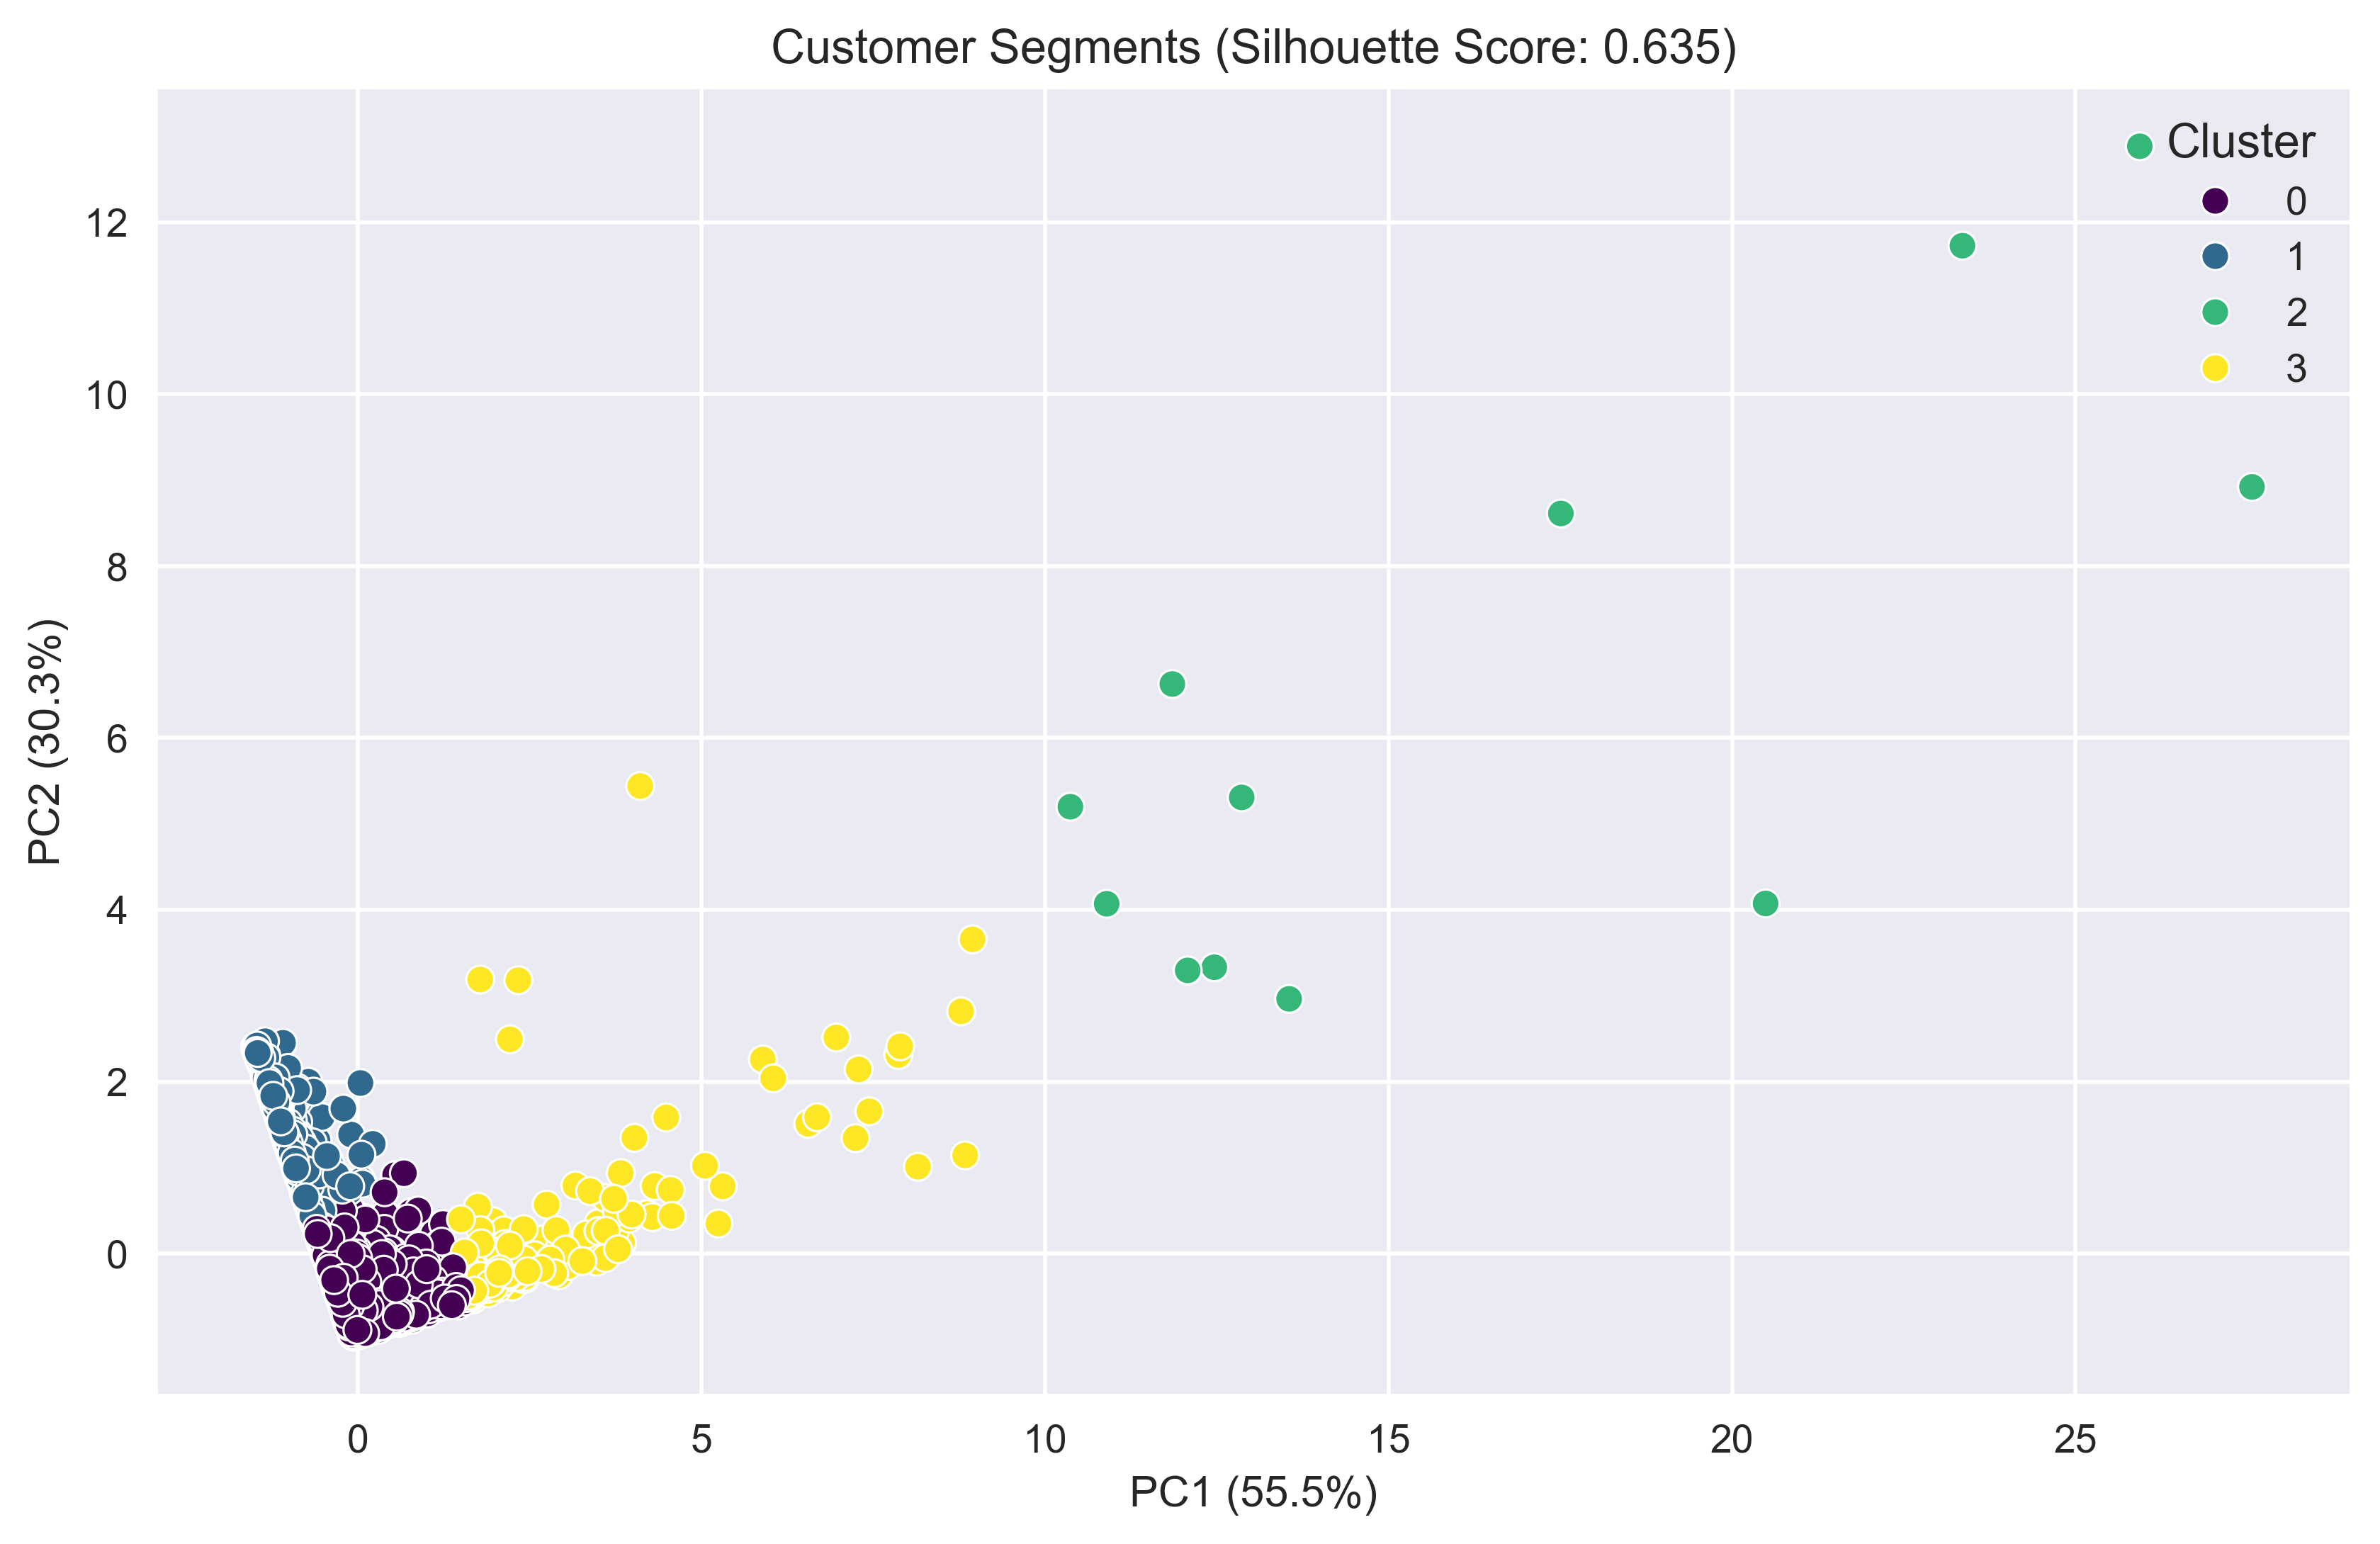

In [308]:
# Visualize clusters in PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=50)
plt.title(f'Customer Segments (Silhouette Score: {score:.3f})')
plt.xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]:.1%})')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#### CLUSTER-PROFILING-FOR-EACH-GROUP-SAMPLE

* Specifying Descriptive stats for each group

In [309]:

## assigning Clusters to the Unscaled dataframe for better Interpretability
## assign 4 clusters
rfm_data['Cluster']= rfm_data_scaled_df['4_Cluster_Label']
## assigining 3 clusters
rfm_data['3_Clusters'] = rfm_data_scaled_df['3_Cluster_Label']
## adding to retail data        

In [310]:
## checking the frequencies   
rfm_data['Cluster'].value_counts()

Cluster
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64

In [311]:
## percentages    
rfm_data['Cluster'].value_counts(normalize=True).round(2)*100

Cluster
0    70.0
1    25.0
3     5.0
2     0.0
Name: proportion, dtype: float64

In [312]:
## for the 3 clusters  
## checking the frequencies   
rfm_data['3_Clusters'].value_counts()

3_Clusters
0    3231
1    1093
2      14
Name: count, dtype: int64

In [313]:
## normalized
rfm_data['3_Clusters'].value_counts(normalize=True).round(2)*100

3_Clusters
0    74.0
1    25.0
2     0.0
Name: proportion, dtype: float64

In [314]:
## characteristics of cluster 0
rfm_data[(rfm_data['Cluster']==0)].describe().round(2)

CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
count     3054.00  3054.00    3054.00   3054.00  3054.00  3054.00  3054.00   
mean     15289.13    43.70       3.68   1353.63     3.54     3.22     3.20   
std       1720.52    35.97       2.86   1540.04     1.06     1.34     1.34   
min      12347.00     1.00       1.00      6.20     2.00     1.00     1.00   
25%      13804.25    15.00       1.00    382.99     3.00     2.00     2.00   
50%      15300.50    32.00       3.00    826.27     4.00     3.00     3.00   
75%      16776.75    65.00       5.00   1783.60     4.00     4.00     4.00   
max      18287.00   163.00      15.00  21429.39     5.00     5.00     5.00   

       RFM_Total_Score  Cluster  3_Clusters  
count          3054.00   3054.0     3054.00  
mean              9.96      0.0        0.01  
std               2.97      0.0        0.08  
min               4.00      0.0        0.00  
25%               8.00      0.0        0.00  
50%              10.00      0.0        0.00  
75%              12.00      0.0        0.00  
max              15.00      0.0        1.00

In [315]:
## charateristics of cluster 1 
rfm_data[(rfm_data['Cluster']==1)].describe().round(2)

CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
count     1067.00  1067.00    1067.00   1067.00  1067.00  1067.00  1067.00   
mean     15347.79   248.08       1.55    478.85     1.19     1.98     2.01   
std       1719.35    66.33       1.07    637.70     0.39     0.99     1.06   
min      12350.00   143.00       1.00      3.75     1.00     1.00     1.00   
25%      13879.50   190.00       1.00    170.40     1.00     1.00     1.00   
50%      15332.00   243.00       1.00    310.26     1.00     2.00     2.00   
75%      16798.00   299.00       2.00    539.63     1.00     3.00     3.00   
max      18281.00   374.00      12.00   9864.26     2.00     5.00     5.00   

       RFM_Total_Score  Cluster  3_Clusters  
count          1067.00   1067.0      1067.0  
mean              5.19      1.0         1.0  
std               1.84      0.0         0.0  
min               3.00      1.0         1.0  
25%               4.00      1.0         1.0  
50%               5.00      1.0         1.0  
75%               6.00      1.0         1.0  
max              12.00      1.0         1.0

In [316]:
## charateristics of cluster 2
rfm_data[(rfm_data['Cluster']==2)].describe().round(2)

CustomerID  Recency  Frequency   Monetary  R_Score  F_Score  M_Score  \
count       13.00    13.00      13.00      13.00    13.00    13.00     13.0   
mean     15435.00     7.38      82.54  127187.96     4.77     4.85      5.0   
std       1979.88    11.49      63.26   79842.36     0.60     0.55      0.0   
min      12415.00     1.00       2.00   33053.19     3.00     3.00      5.0   
25%      14156.00     1.00      46.00   60632.75     5.00     5.00      5.0   
50%      15311.00     2.00      63.00  117210.08     5.00     5.00      5.0   
75%      17450.00     8.00      97.00  168472.50     5.00     5.00      5.0   
max      18102.00    39.00     209.00  280206.02     5.00     5.00      5.0   

       RFM_Total_Score  Cluster  3_Clusters  
count            13.00     13.0        13.0  
mean             14.62      2.0         2.0  
std               0.77      0.0         0.0  
min              13.00      2.0         2.0  
25%              15.00      2.0         2.0  
50%              15.00      2.0         2.0  
75%              15.00      2.0         2.0  
max              15.00      2.0         2.0

In [317]:
## charateristics of cluster 3
rfm_data[(rfm_data['Cluster']==3)].describe().round(2)

CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
count      204.00   204.00     204.00    204.00   204.00   204.00   204.00   
mean     15212.86    15.50      22.33  12690.50     4.63     4.96     4.99   
std       1743.76    40.92      11.68  13165.76     0.79     0.34     0.12   
min      12346.00     1.00       1.00   1296.44     1.00     1.00     4.00   
25%      13740.50     2.75      15.00   5418.18     4.00     5.00     5.00   
50%      15134.50     5.00      19.00   7990.20     5.00     5.00     5.00   
75%      16733.00    14.25      26.00  13714.14     5.00     5.00     5.00   
max      18283.00   372.00      93.00  77183.60     5.00     5.00     5.00   

       RFM_Total_Score  Cluster  3_Clusters  
count           204.00    204.0      204.00  
mean             14.57      3.0        0.03  
std               1.02      0.0        0.20  
min               7.00      3.0        0.00  
25%              14.00      3.0        0.00  
50%              15.00      3.0        0.00  
75%              15.00      3.0        0.00  
max              15.00      3.0        2.00

In [318]:
# Step 1: Statistical Summary
cluster_profile_original = rfm_data.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'count'],
    'Frequency': ['mean', 'median', 'count'],
    'Monetary': ['mean', 'median', 'count']
}).reset_index().round(2)

# Rename columns for clarity
cluster_profile_original.columns = ['Cluster', 'Recency_Mean', 'Recency_Median', 'Recency_Count',
                          'Frequency_Mean', 'Frequency_Median', 'Frequency_Count',
                          'Monetary_Mean', 'Monetary_Median', 'Monetary_Count']

## print the original cluster lables  
cluster_profile_original

Cluster  Recency_Mean  Recency_Median  Recency_Count  Frequency_Mean  \
0        0         43.70            32.0           3054            3.68   
1        1        248.08           243.0           1067            1.55   
2        2          7.38             2.0             13           82.54   
3        3         15.50             5.0            204           22.33   

   Frequency_Median  Frequency_Count  Monetary_Mean  Monetary_Median  \
0               3.0             3054        1353.63           826.27   
1               1.0             1067         478.85           310.26   
2              63.0               13      127187.96        117210.08   
3              19.0              204       12690.50          7990.20   

   Monetary_Count  
0            3054  
1            1067  
2              13  
3             204

* Visual Inspections

* Boxplot

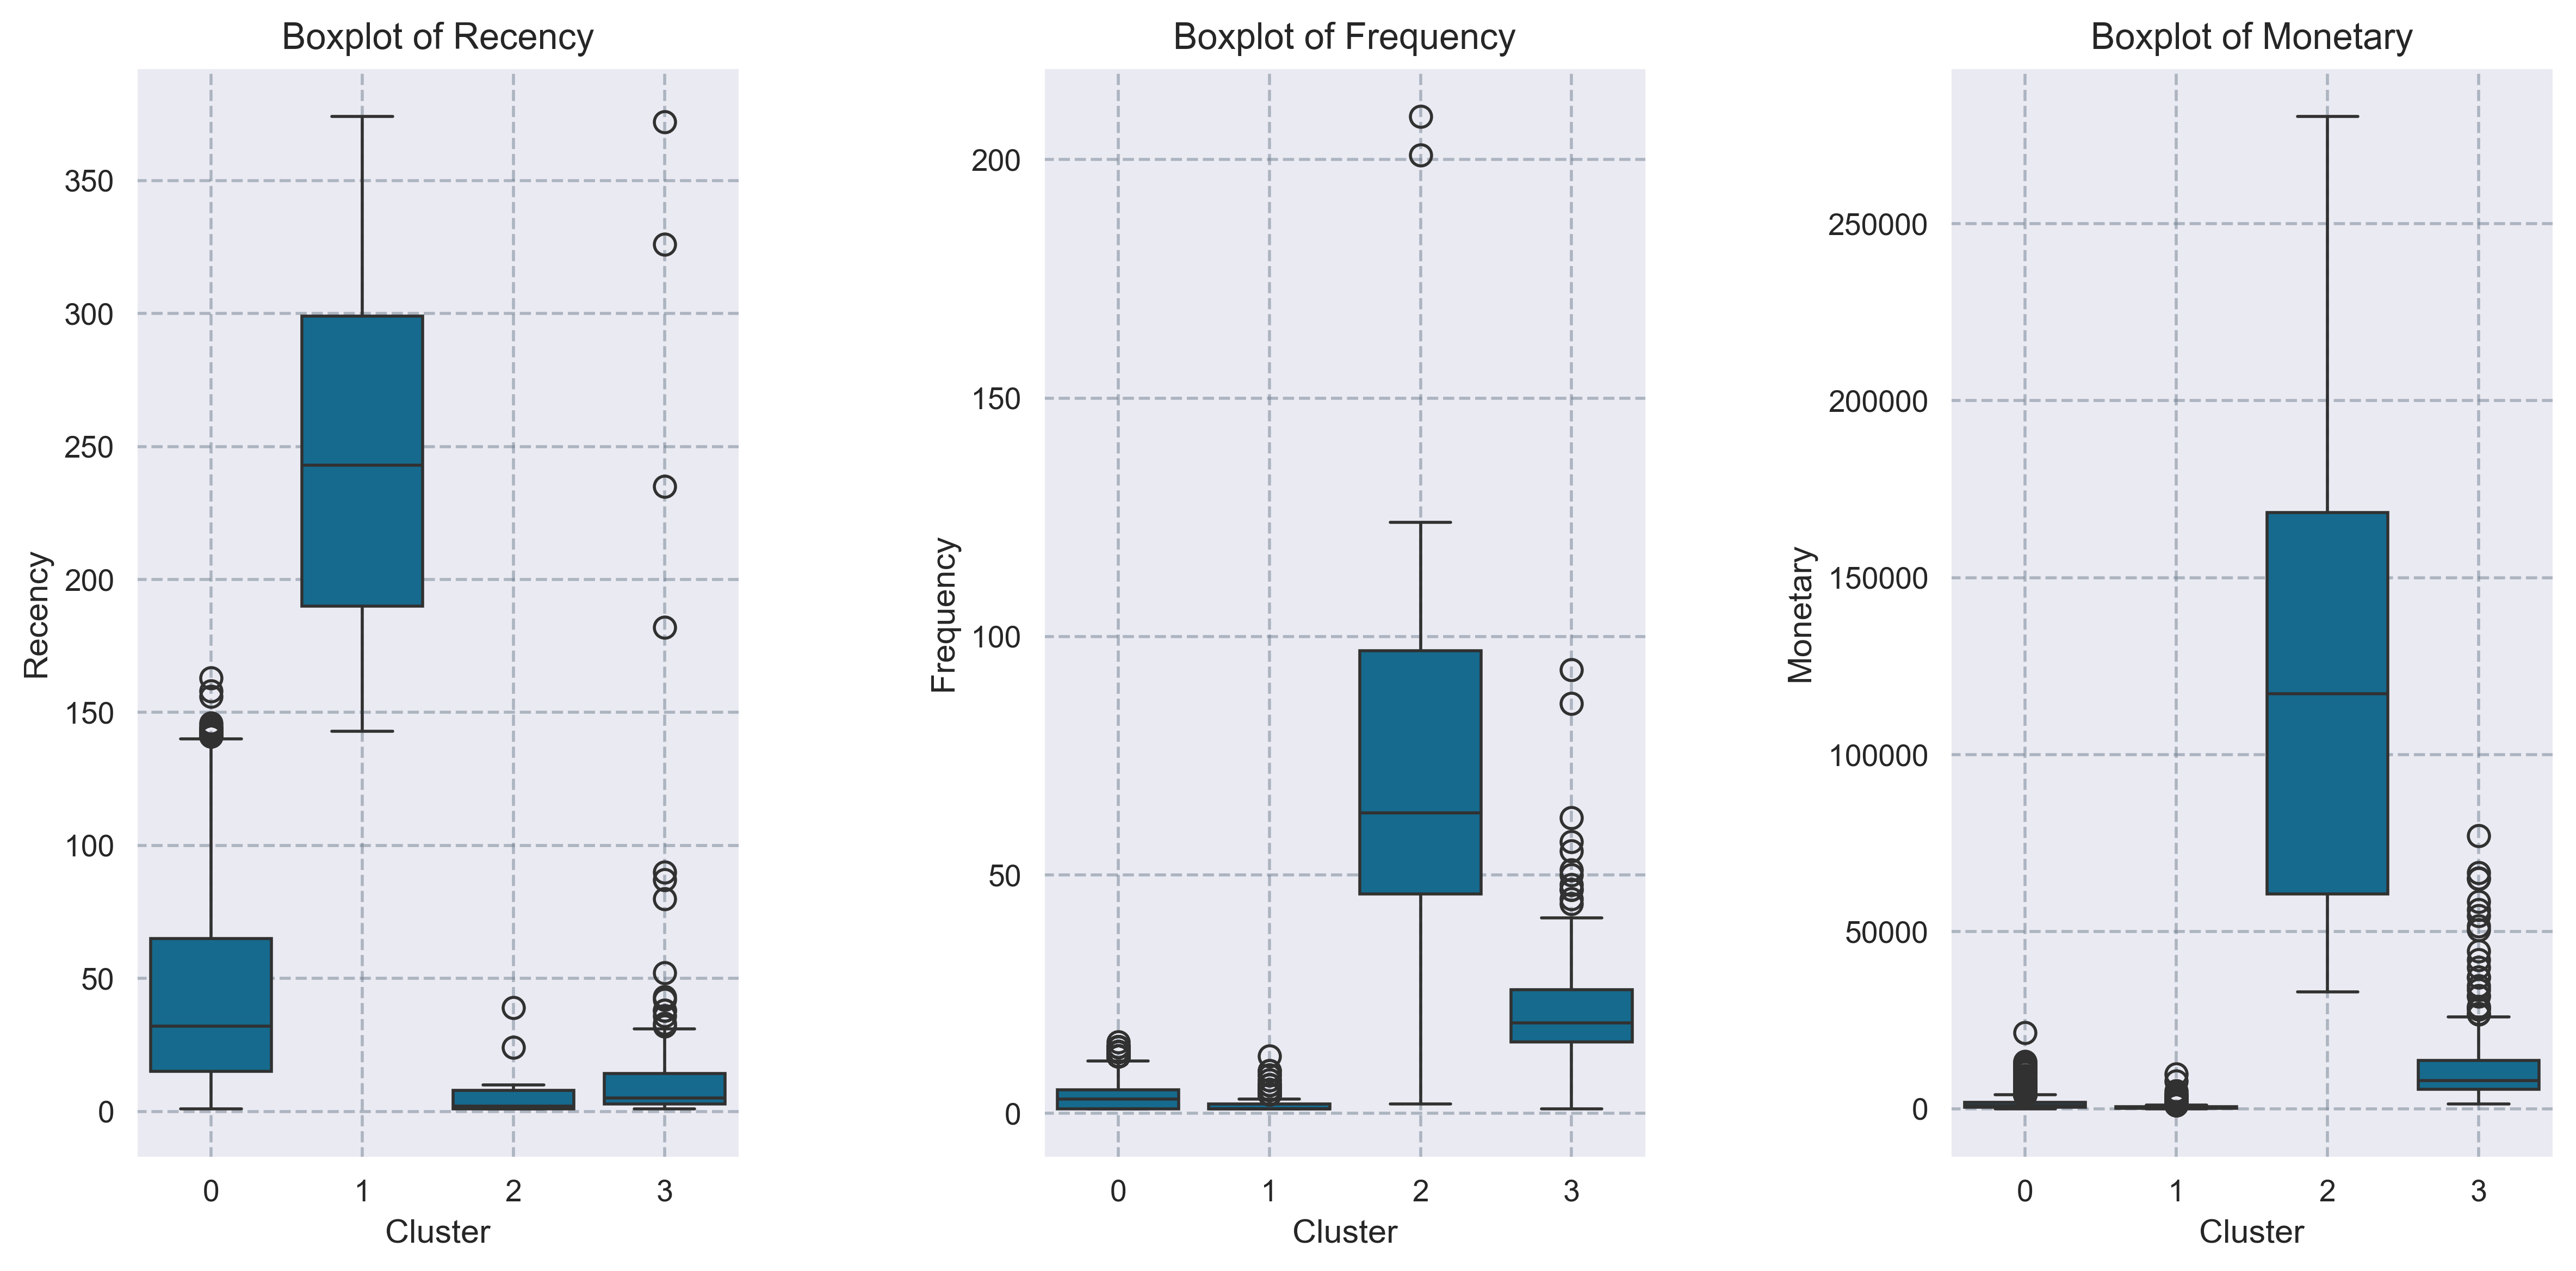

In [319]:
## boxplots
plt.figure(figsize=(12, 6))
for i, metric in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=metric, data=rfm_data)
    plt.title(f'Boxplot of {metric}')
    plt.xlabel('Cluster')
    plt.ylabel(metric)
    plt.grid(True,ls='--',alpha=0.5,color='SlateGrey')


plt.tight_layout()
plt.subplots_adjust(wspace=.5)
plt.show()


* Barplot

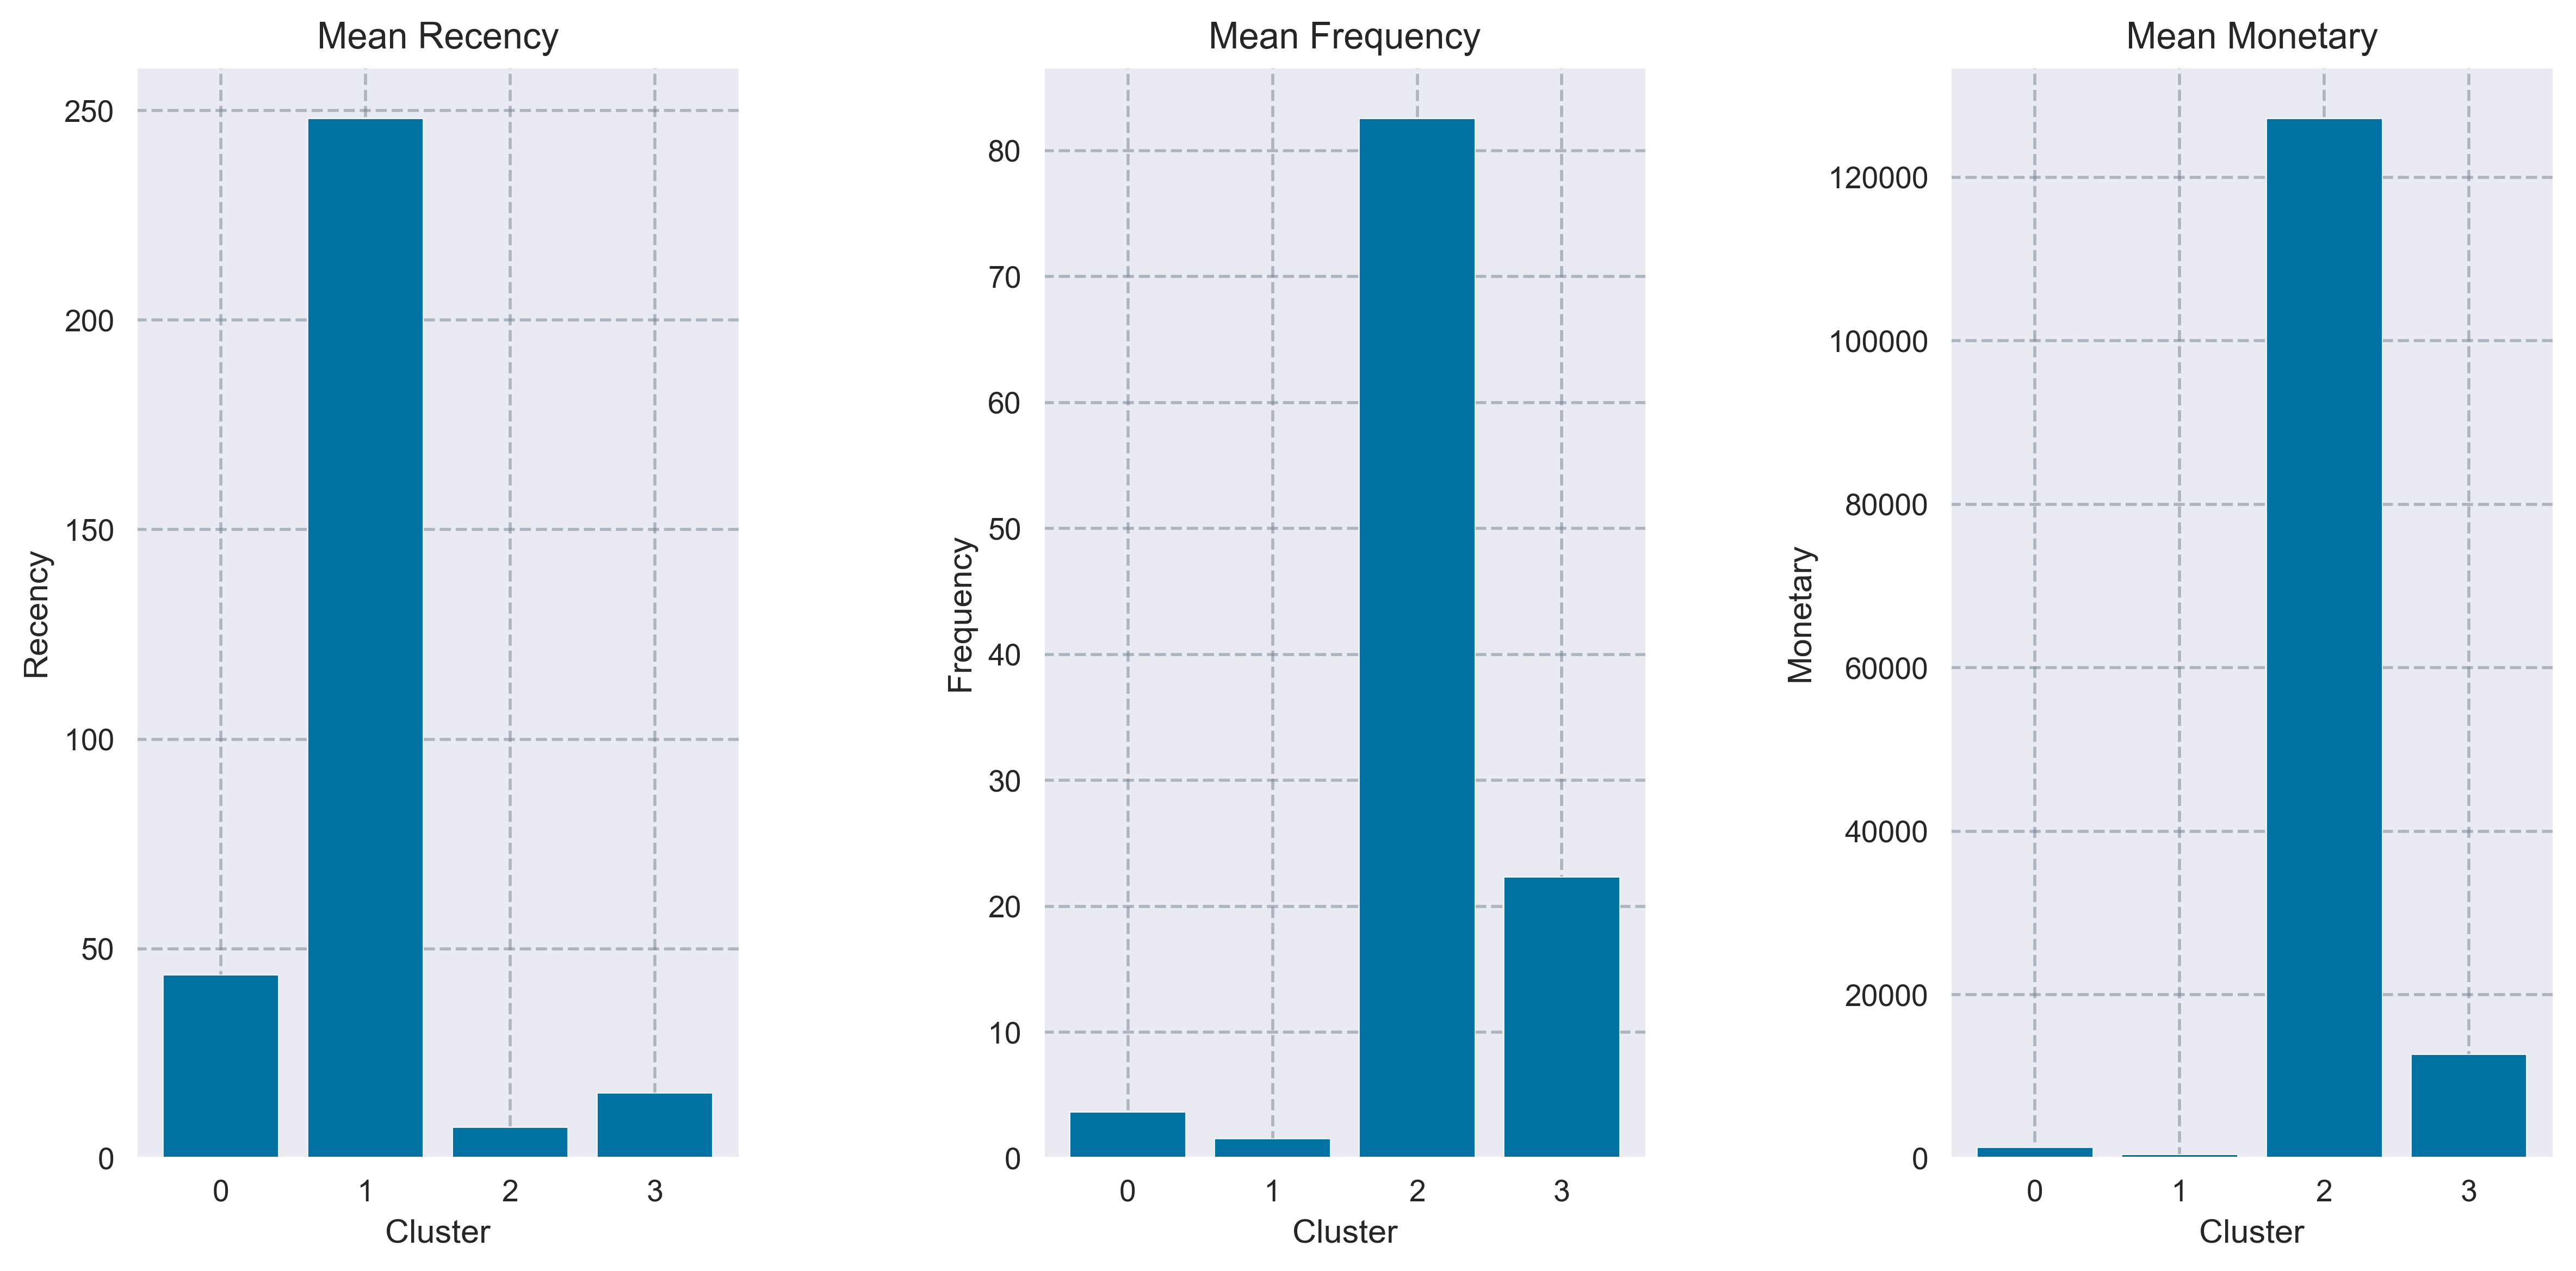

In [320]:
## Barplots
cluster_means = rfm_data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

plt.figure(figsize=(12, 6))
for i, metric in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    plt.bar(cluster_means['Cluster'], cluster_means[metric])
    plt.title(f'Mean {metric}')
    plt.xlabel('Cluster')
    plt.ylabel(metric)
    plt.grid(True,ls='--',alpha=0.5,color='SlateGrey')
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()

* Inspecting via Silhouette Scores for each group sample

In [321]:

## When the there are 4 clusters
## get the silhouette samples for each group sample
sil_samples = silhouette_samples(rfm_data_scaled, labels_)
## assign to the dataframe
rfm_data['Silhouette'] = sil_samples
## group by Clsuter and average the silhouette scores
silhouette_by_cluster = rfm_data.groupby('Cluster')['Silhouette'].mean()
## print
print("Silhouette Score by Cluster:")
## display output
print(silhouette_by_cluster)

Silhouette Score by Cluster:
Cluster
0    0.656652
1    0.582023
2    0.054214
3    0.225774
Name: Silhouette, dtype: float64


In [322]:
## When there are 3 Clusters
## get the silhouette samples for each group sample
sil_samples = silhouette_samples(rfm_data_scaled, labels_)
## assign to the dataframe
rfm_data['Silhouette'] = sil_samples
## group by Clsuter and average the silhouette scores
silhouette_by_cluster_3 = rfm_data.groupby('3_Clusters')['Silhouette'].mean()
## print
print("Silhouette Score by Cluster:")
## display
print(silhouette_by_cluster_3)

Silhouette Score by Cluster:
3_Clusters
0    0.634746
1    0.568515
2    0.067502
Name: Silhouette, dtype: float64


##### Assigning Clusters with conventional names based on the profiles

In [323]:

# assigning conventional names
cluster_names = {
    0: "Loyal Customers",
    1: "At-Risk",
    2: "Champions",
    3: "Potential Champions"
}
## applying it to the data 
rfm_data['Customer_segments'] = rfm_data['Cluster'].map(cluster_names)

In [324]:
## display the data again  
rfm_data.head()

CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0     12346.0      326          1  77183.60        1        1        5   
1     12347.0        2          7   4310.00        5        5        5   
2     12348.0       75          4   1797.24        2        4        4   
3     12349.0       19          1   1757.55        4        1        4   
4     12350.0      310          1    334.40        1        1        2   

  RFM_Score  RFM_Total_Score  Cluster  3_Clusters  Silhouette  \
0       115                7        3           1    0.009699   
1       555               15        0           0    0.669643   
2       244               10        0           0    0.671320   
3       414                9        0           0    0.741149   
4       112                4        1           1    0.709066   

     Customer_segments  
0  Potential Champions  
1      Loyal Customers  
2      Loyal Customers  
3      Loyal Customers  
4              At-Risk

*  visual Inspections after applying conventional names

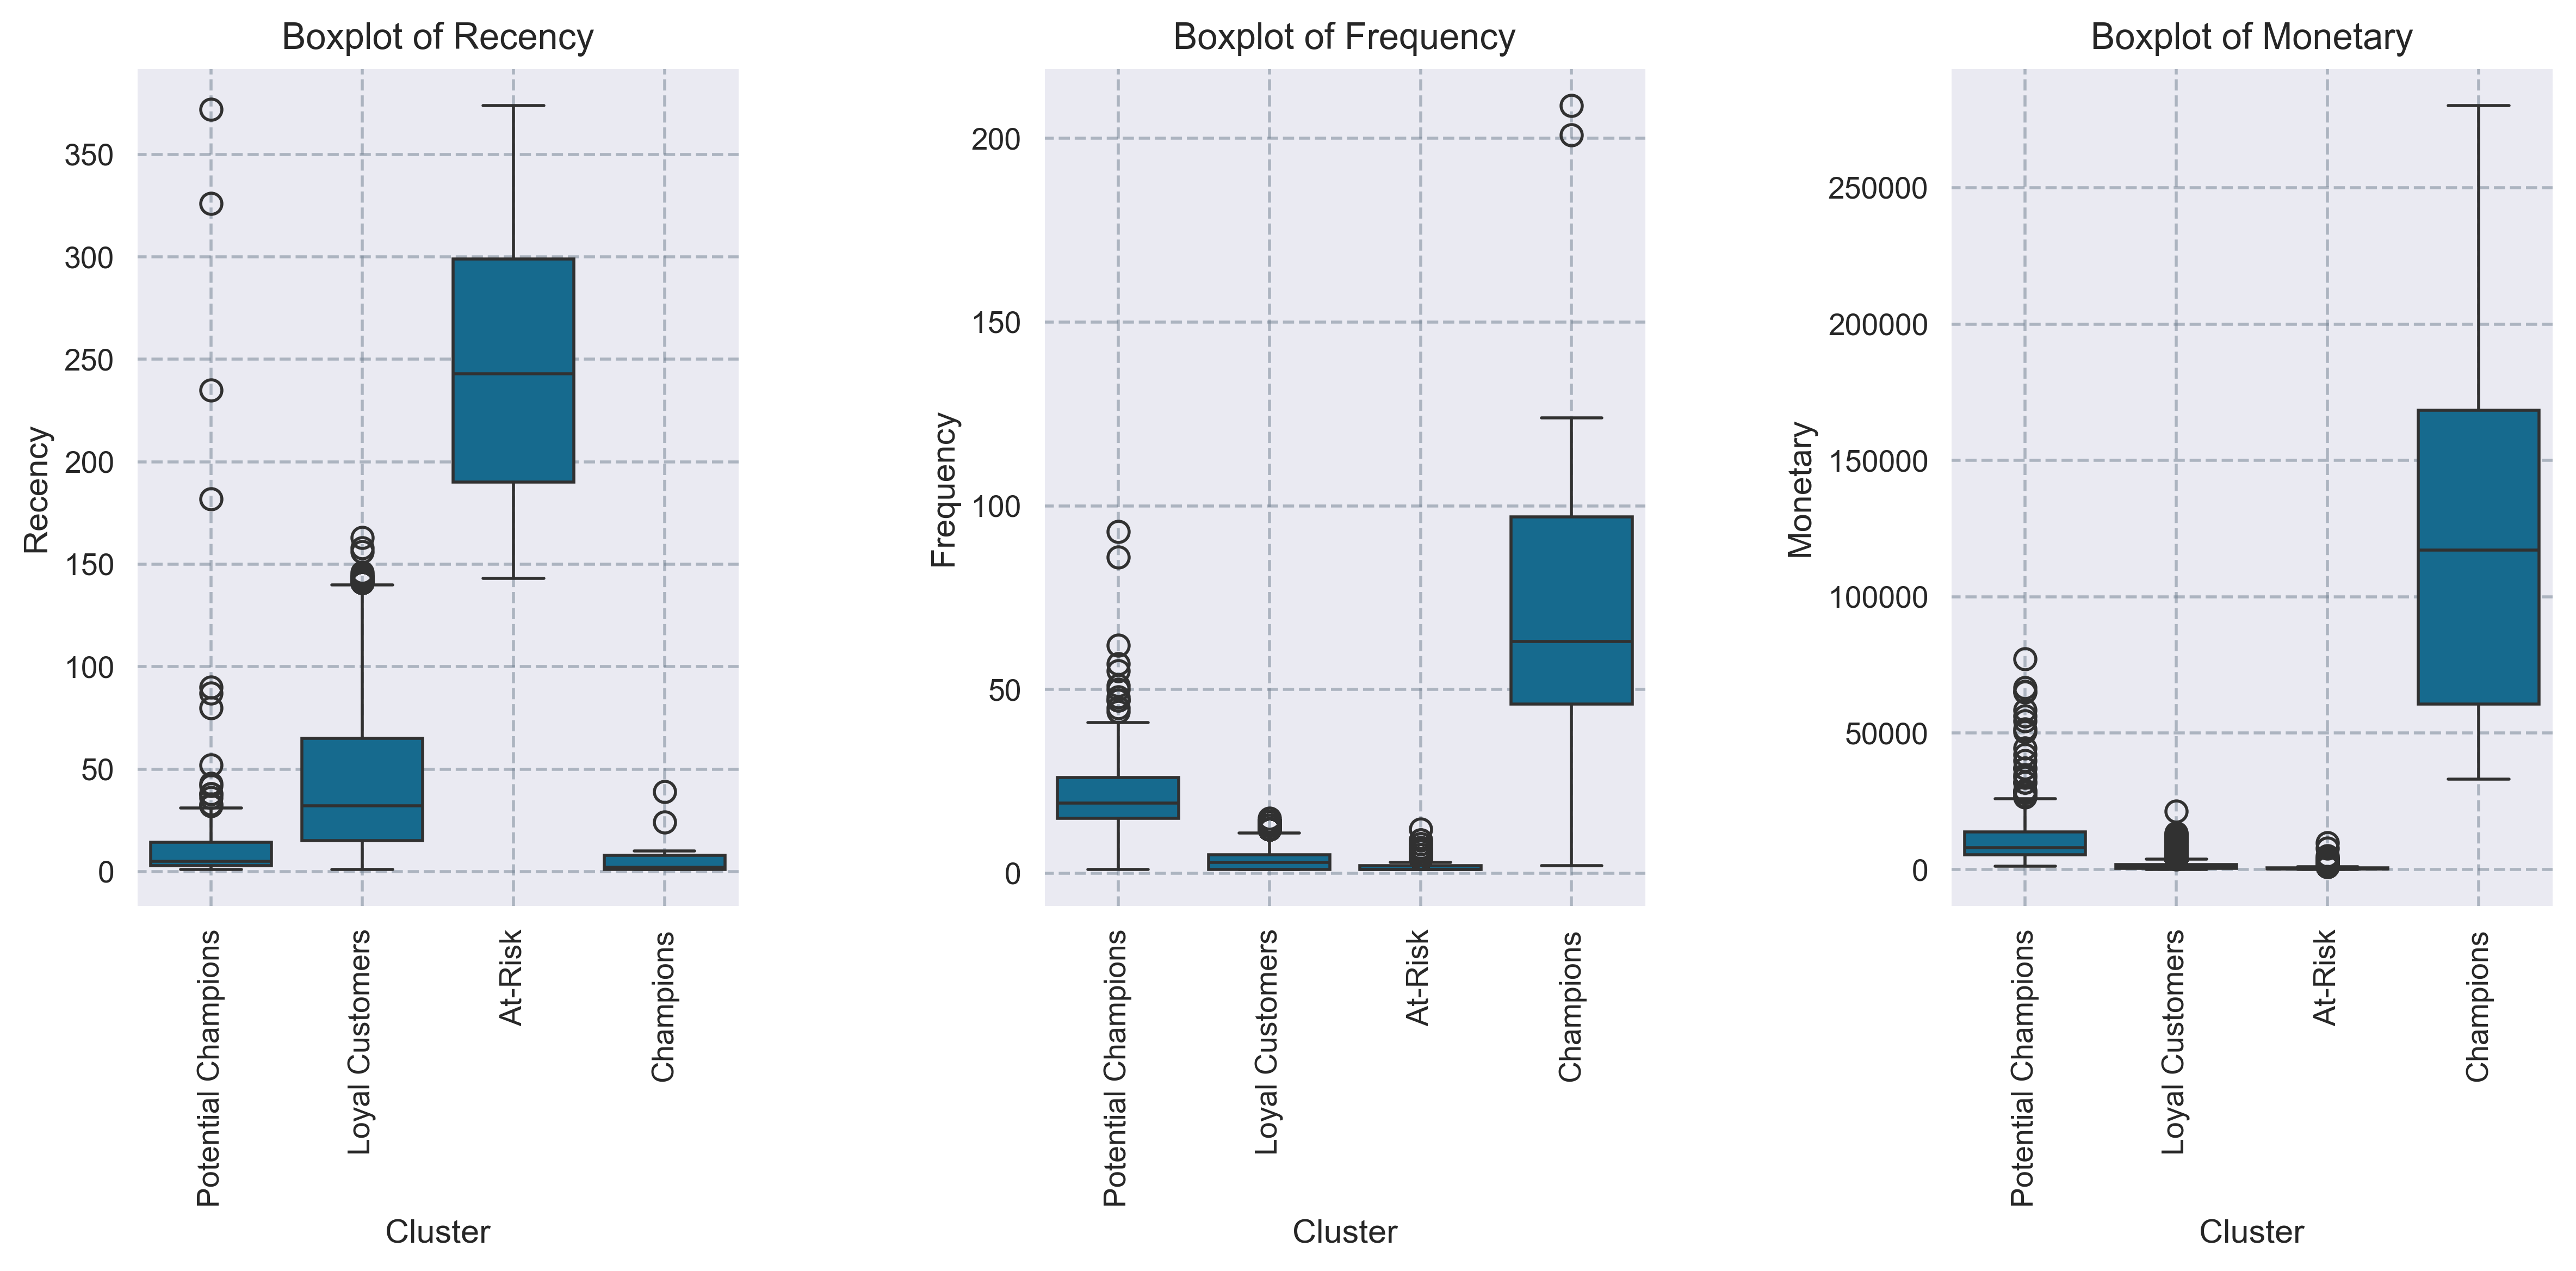

In [325]:
## boxplots
plt.figure(figsize=(12, 6))
for i, metric in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Customer_segments', y=metric, data=rfm_data)
    plt.title(f'Boxplot of {metric}')
    plt.xlabel('Cluster')
    plt.ylabel(metric)
    plt.xticks(rotation=90)
    plt.grid(True,ls='--',alpha=0.5,color='SlateGrey')


plt.tight_layout()
plt.subplots_adjust(wspace=.5)

plt.show()


In [326]:
# # creating a bar grouped bar graph
segmented_group = rfm_data.groupby('Customer_segments')[['R_Score','F_Score','M_Score']].mean().reset_index().round(2)
segmented_group

Customer_segments  R_Score  F_Score  M_Score
0              At-Risk     1.19     1.98     2.01
1            Champions     4.77     4.85     5.00
2      Loyal Customers     3.54     3.22     3.20
3  Potential Champions     4.63     4.96     4.99

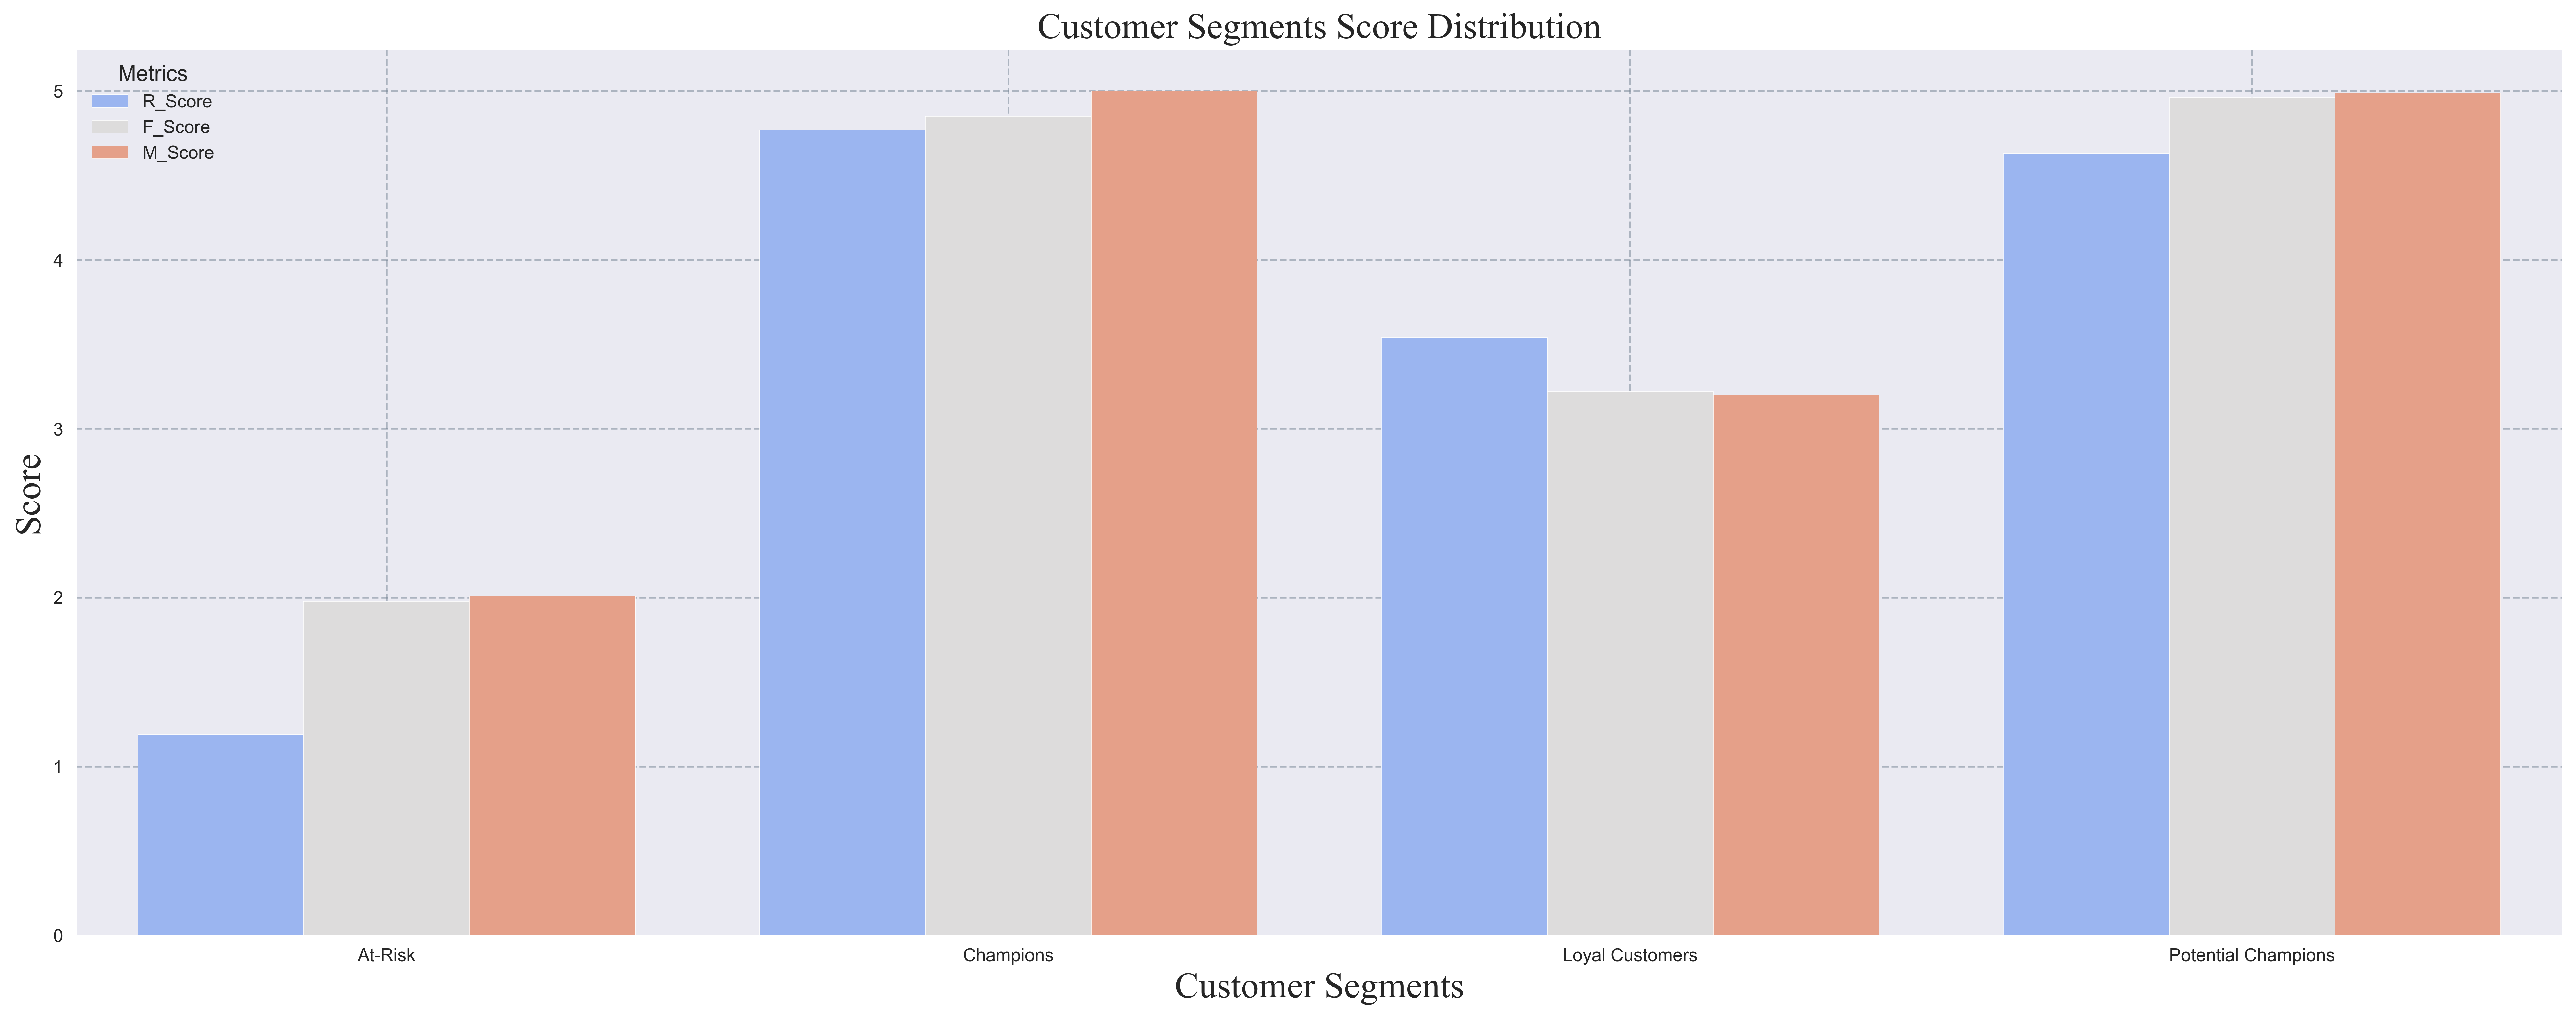

In [327]:
# Convert from wide to long format
df_melted = segmented_group.melt(id_vars=['Customer_segments'], var_name='Metric', value_name='Score')
# Plot
plt.figure(figsize=(20, 8))
sns.barplot(data=df_melted, x='Customer_segments', y='Score', hue='Metric', palette='coolwarm')
plt.title('Customer Segments Score Distribution',fontfamily='Times New Roman',fontsize=20)
plt.xlabel('Customer Segments',fontfamily='Times New Roman',fontsize=20)
plt.ylabel('Score',fontfamily='Times New Roman',fontsize=20)
plt.legend(title="Metrics")
plt.tight_layout()
plt.grid(True,ls='--',alpha=0.5,color='SlateGrey')
plt.subplots_adjust()
plt.show()

In [340]:
# Monthly Spend by Champions
vip_customers = rfm_data[rfm_data['Customer_segments'] == 'Champions']['CustomerID']
vip_transactions = retail_data[retail_data['CustomerID'].isin(vip_customers)].copy()
monthly_spend = vip_transactions.resample('ME', on='InvoiceDate')['Total_Revenue'].sum()
monthly_spend = monthly_spend.reset_index()

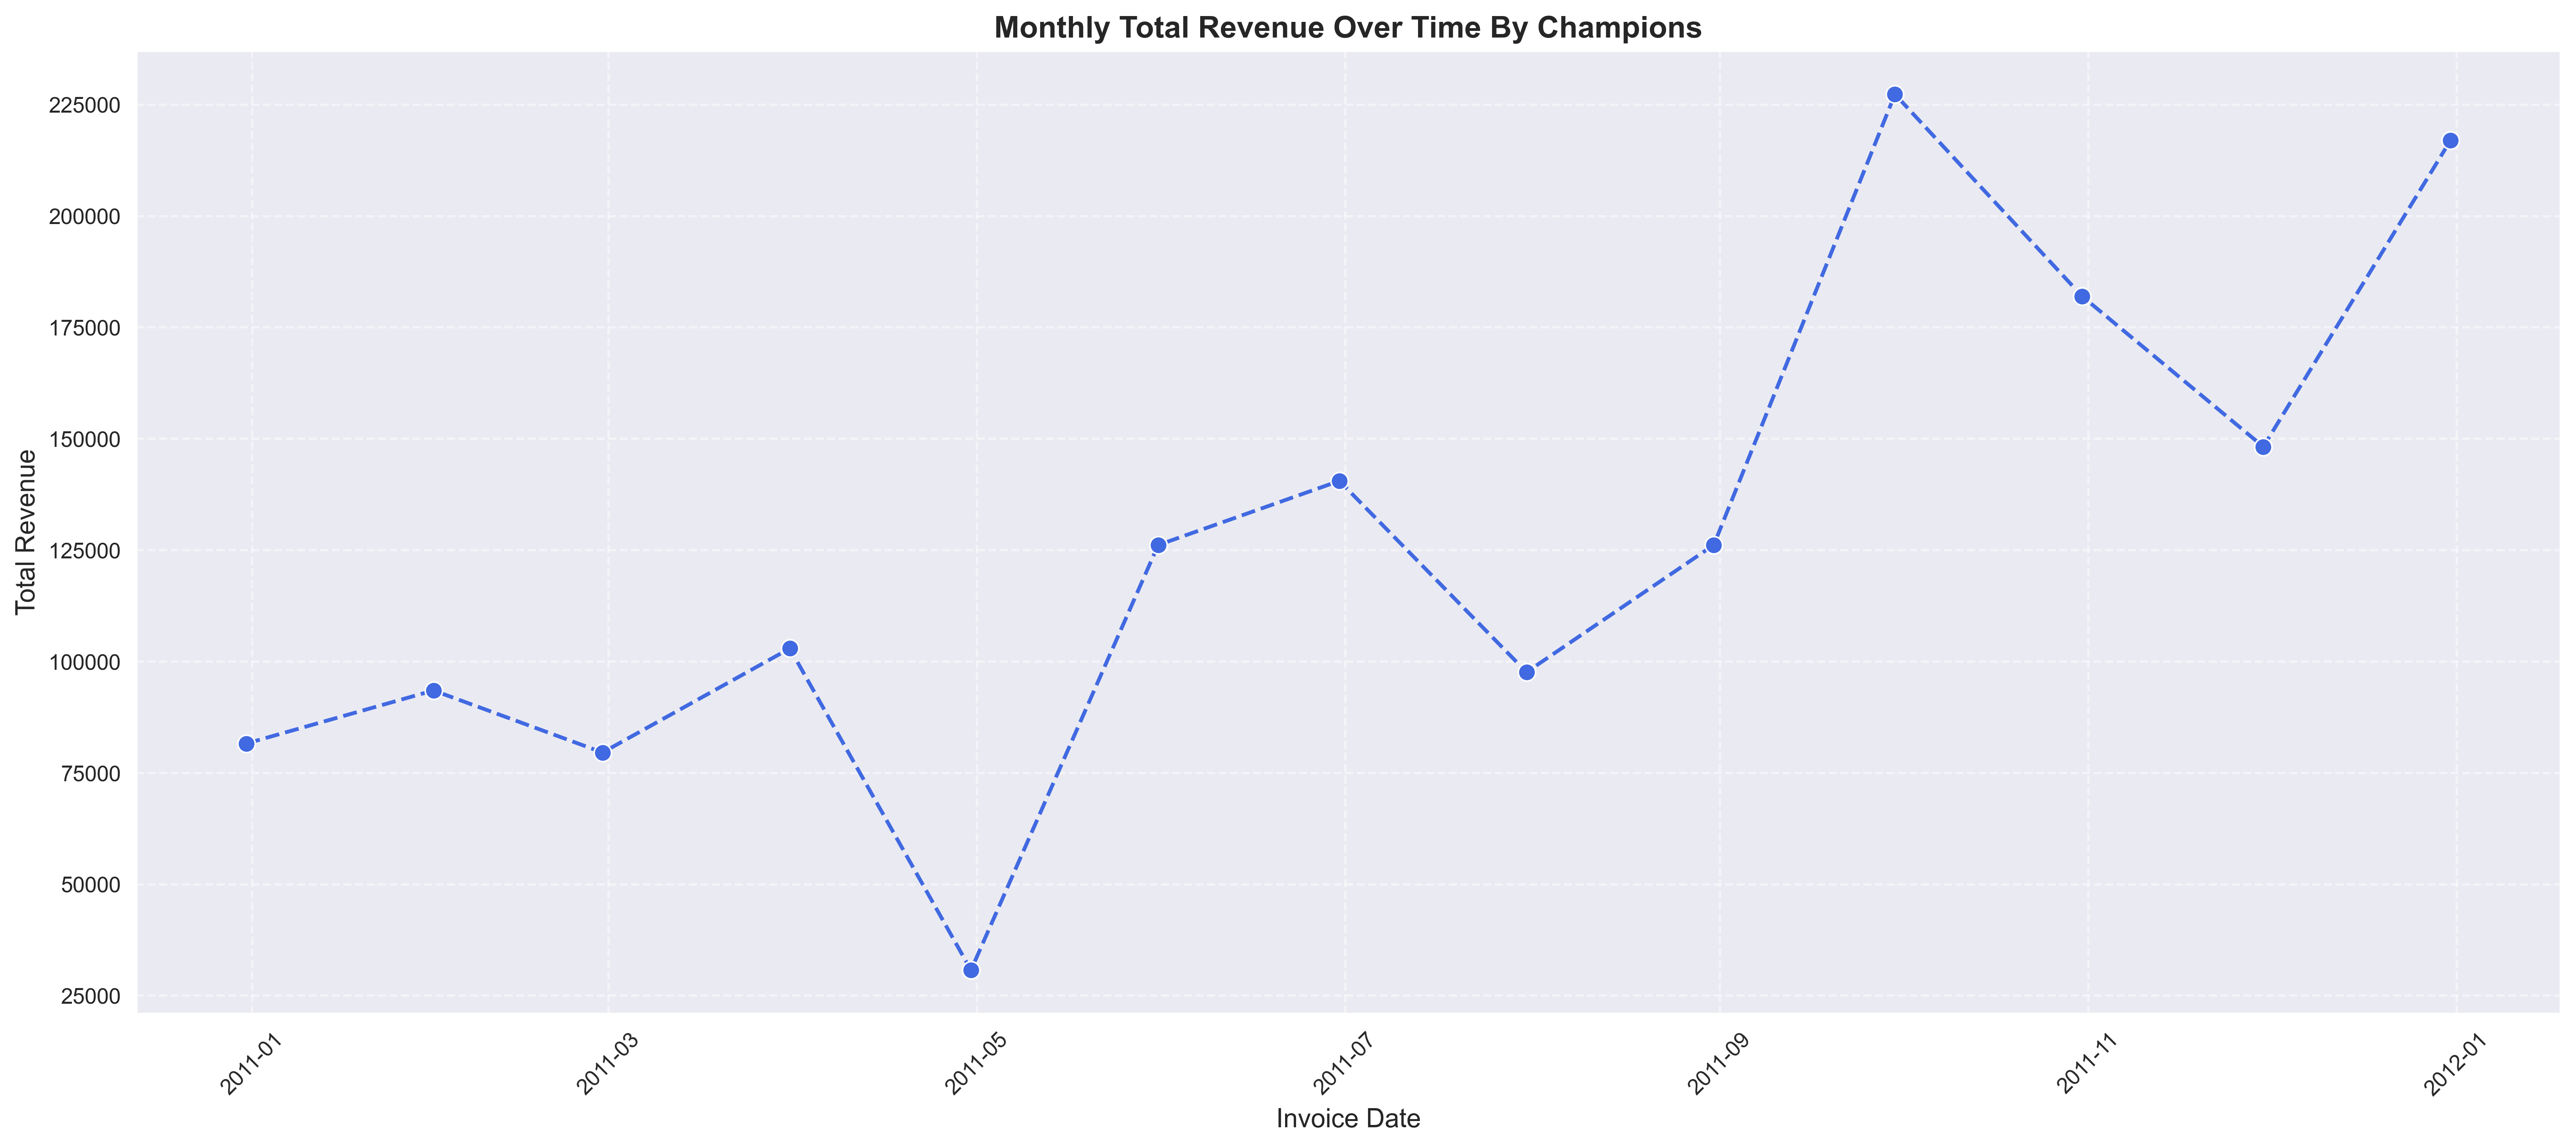

In [343]:
## plotting
plt.figure(figsize=(20,8)) 
sns.lineplot(
    data=monthly_spend, 
    x='InvoiceDate', 
    y='Total_Revenue', 
    marker='o',
    markersize=8,
    linestyle='--', 
    color='royalblue', 
    errorbar=("ci", 95) 
)

plt.xlabel("Invoice Date", fontsize=12)  
plt.ylabel("Total Revenue", fontsize=12)  
plt.title("Monthly Total Revenue Over Time By Champions", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5) 


##### correlations

In [344]:
## get the correlations
correlations = rfm_data.groupby('Customer_segments')[['Recency', 'Frequency', 'Monetary']].corr()
correlations

Recency  Frequency  Monetary
Customer_segments                                           
At-Risk             Recency    1.000000  -0.267944 -0.141592
                    Frequency -0.267944   1.000000  0.468419
                    Monetary  -0.141592   0.468419  1.000000
Champions           Recency    1.000000  -0.310065 -0.143143
                    Frequency -0.310065   1.000000 -0.365209
                    Monetary  -0.143143  -0.365209  1.000000
Loyal Customers     Recency    1.000000  -0.303772 -0.183564
                    Frequency -0.303772   1.000000  0.638805
                    Monetary  -0.183564   0.638805  1.000000
Potential Champions Recency    1.000000  -0.183608  0.245111
                    Frequency -0.183608   1.000000  0.214551
                    Monetary   0.245111   0.214551  1.000000

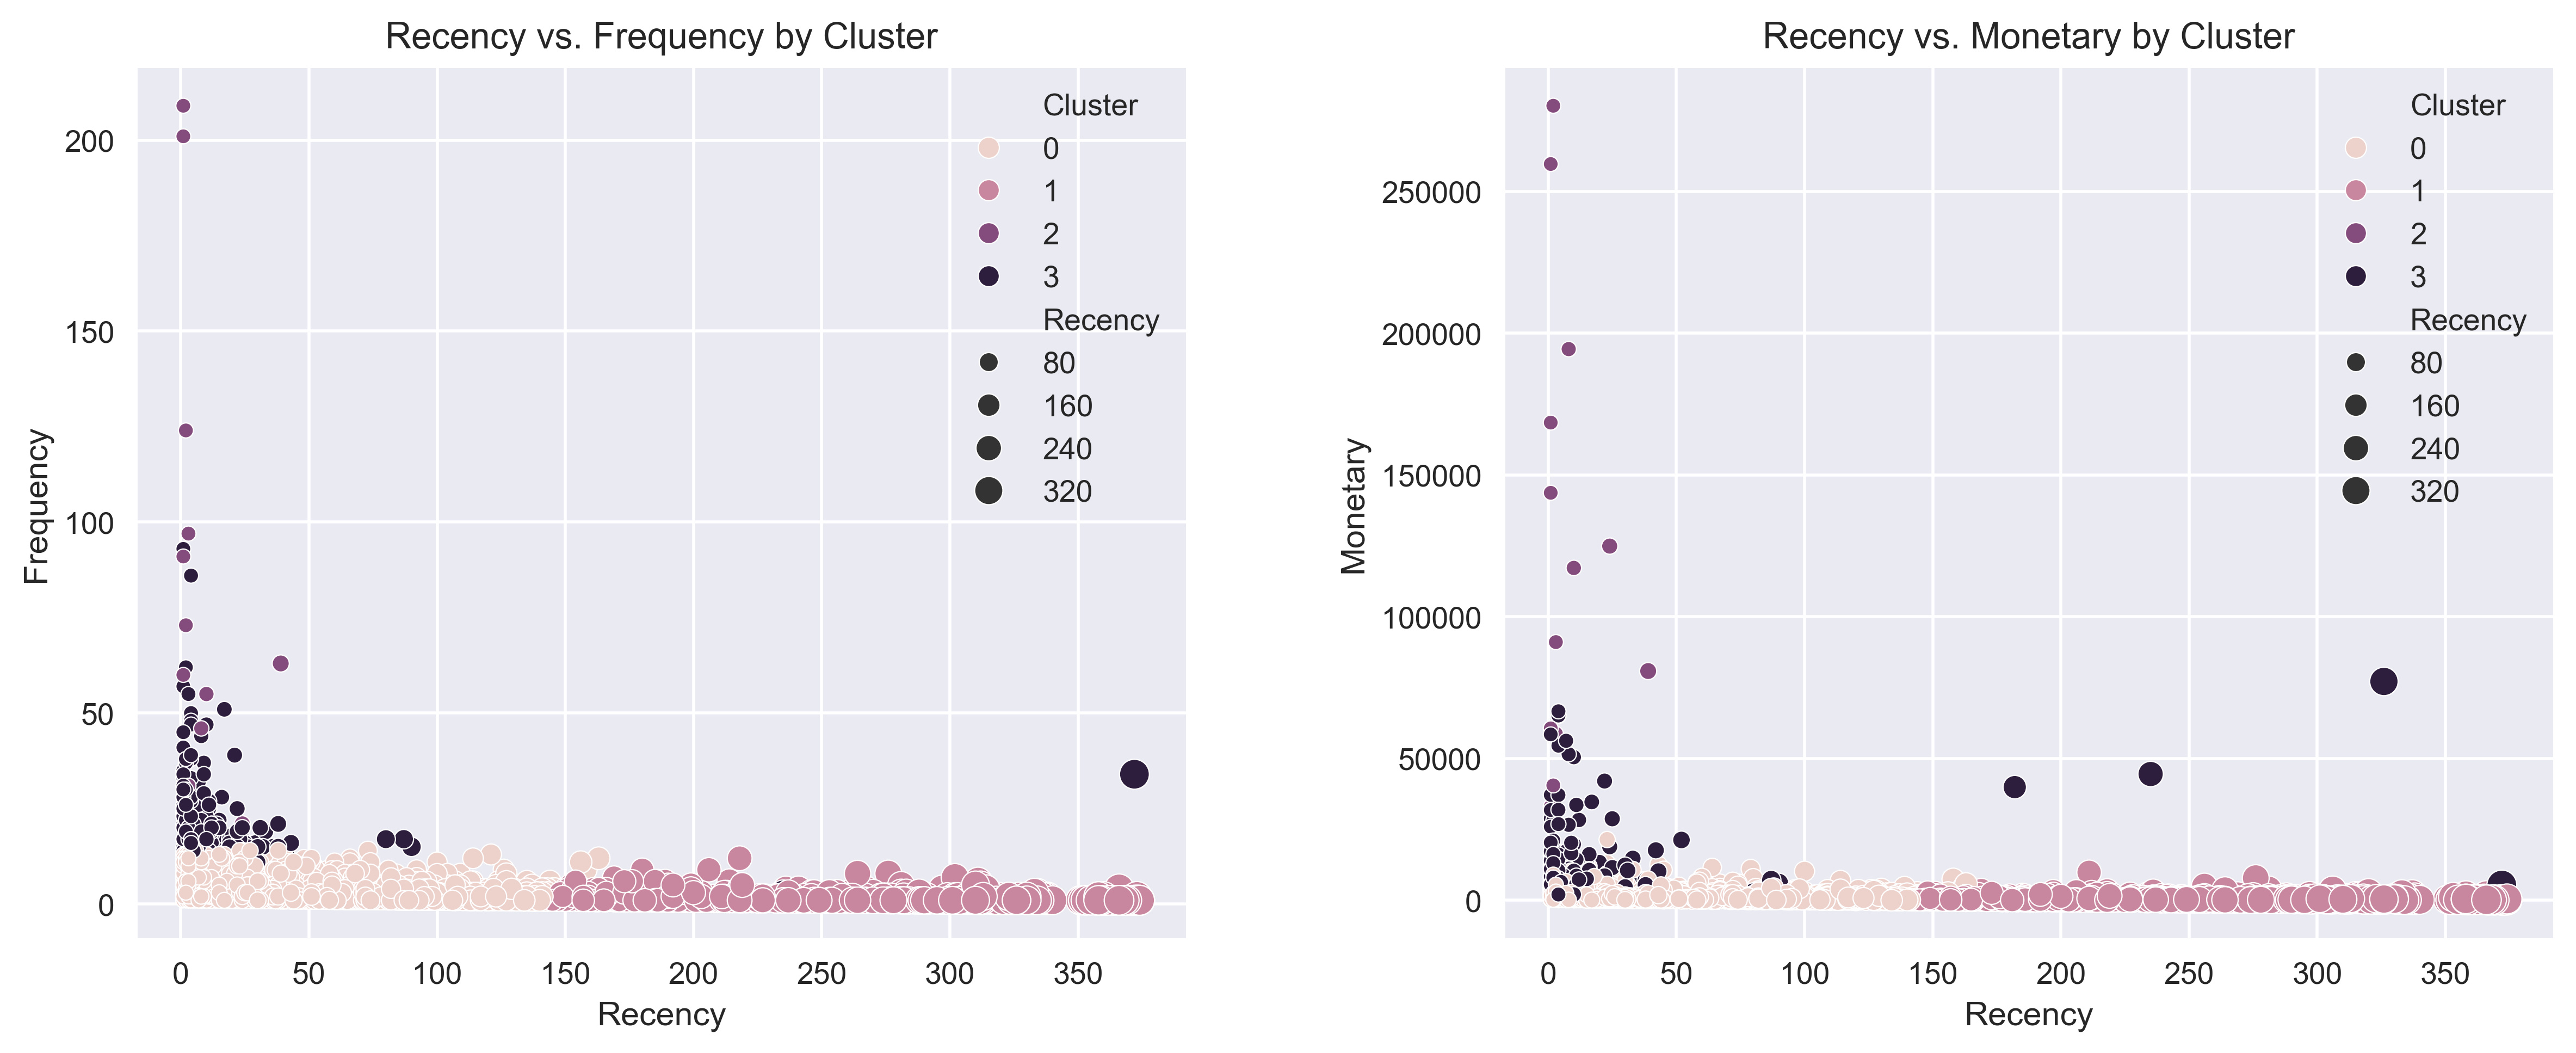

In [ ]:
## plotting relationships
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=rfm_data, x='Recency', y='Frequency', hue='Cluster',size='Recency')
plt.title('Recency vs. Frequency by Cluster')
plt.subplot(1, 2, 2)
sns.scatterplot(data=rfm_data, x='Recency', y='Monetary', hue='Cluster',size='Recency')
plt.title('Recency vs. Monetary by Cluster')
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

#####  Driving Variable for Predicting Cluster Segments

In [332]:
# Train a model to predict clusters from RFM metrics
X = rfm_data[['Recency', 'Frequency', 'Monetary']]
y = rfm_data['Cluster']
model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)

RandomForestClassifier()

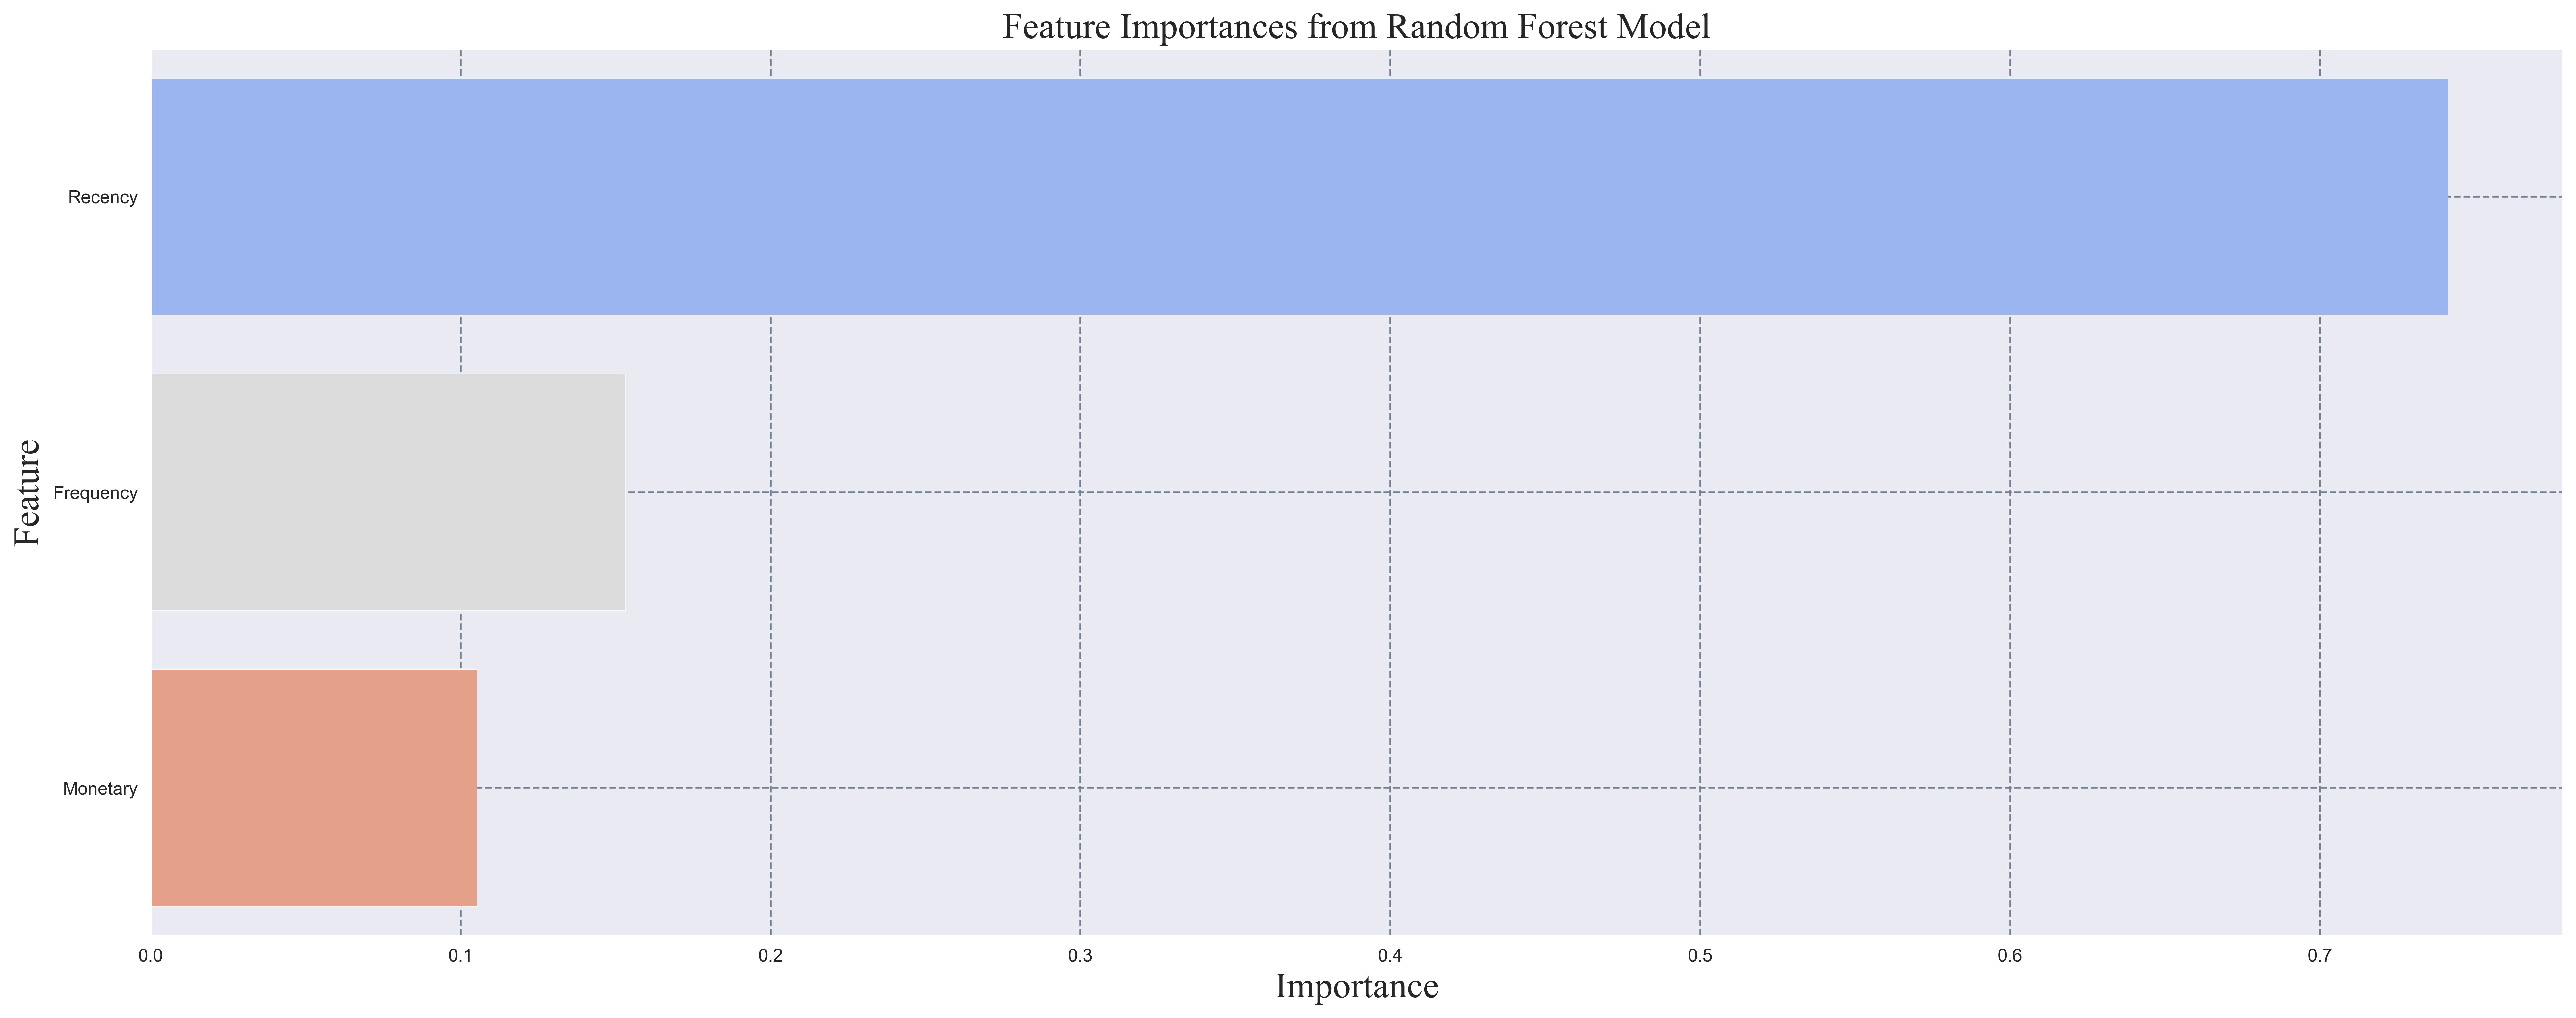

In [ ]:
# Extract feature importances
importances = model.feature_importances_
## features
features = X.columns

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(20, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='coolwarm')
plt.title('Feature Importances from Random Forest Model',fontfamily='Times New Roman',fontsize=20)
plt.xlabel('Importance',fontfamily='Times New Roman',fontsize=20)
plt.ylabel('Feature',fontfamily='Times New Roman',fontsize=20)
plt.tight_layout()
plt.subplots_adjust()
plt.grid(True,ls='--',color='SlateGrey')
plt.show()